# Update Holding Six Analysis

The following project is an update to a previous project, where we analysed/tried to predict, which player is the best for the vaccant holding six position at FC Bayern Munich.

In [1]:
#!pip install umap-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score,pairwise_distances,calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity,NearestNeighbors
from sklearn.cluster import DBSCAN,HDBSCAN,MeanShift
from sklearn.preprocessing import RobustScaler,PowerTransformer
#from pyclustering.metrics import dunn_index
import umap
import optuna
import optuna.visualization.matplotlib as optuna_matplotlib
#pd.set_option('display.max_columns',120)
#pd.set_option('display.max_rows',120)

In [2]:
#filtering it down to only middfielder as main postion and as second postion defender
df=pd.read_csv(r"C:\Users\gandj\OneDrive\Desktop\Case_Study\Football\Holding_Six\Data Source\Europe_Football_Players.csv")
df_mf=df[(df['Main_Pos']=='MF')&((df['Sec_Pos']=='MF') | (df['Sec_Pos']=='DF'))].iloc[:,1:]
df_mf.head()

Rk             Player Nation Main_Pos Sec_Pos         Squad  Age  Born  \
1    2      George Abbott    ENG       MF      MF     Tottenham   16  2005   
3    4        Tyler Adams     US       MF      MF  Leeds United   23  1999   
12  13   Thiago Alcántara     ES       MF      MF     Liverpool   31  1991   
16  17          Dele Alli    ENG       MF      MF       Everton   26  1996   
20  21  Samuel Amo-Ameyaw    ENG       MF      MF   Southampton   16  2006   

    Total Tackels  TklW  ...  Def_Action_lead_Shot_Att  GCA  GCA90  \
1             0.0   0.0  ...                       0.0  0.0   0.00   
3            89.0  46.0  ...                       0.0  1.0   0.04   
12           43.0  24.0  ...                       3.0  2.0   0.14   
16            0.0   0.0  ...                       0.0  0.0   0.00   
20            0.0   0.0  ...                       0.0  0.0   0.00   

    Live_Pass_lead_Goal  Dead_Pass_lead_Goal  Goal_after_Dribbling  \
1                   0.0                  0.0                   0.0   
3                   1.0                  0.0                   0.0   
12                  2.0                  0.0                   0.0   
16                  0.0                  0.0                   0.0   
20                  0.0                  0.0                   0.0   

    Shot_lead_Goal  Foul_drawn_lead_Goal  Def_Action_lead_Goal  League  
1              0.0                   0.0                   0.0     EPL  
3              0.0                   0.0                   0.0     EPL  
12             0.0                   0.0                   0.0     EPL  
16             0.0                   0.0                   0.0     EPL  
20             0.0                   0.0                   0.0     EPL  

[5 rows x 96 columns]

Next, we will filter down to the most important characteristics of the holding six, but what are the most important charactertistics?

## Characteristics of a Holding Six

### Defensive Responsibilities
#### Tackling
A good "Holding Six" needs to be a strong tackler, therefore we need the following features (Watson, 2022):

-- 'Total Tackles'

-- 'TklW'

-- 'Def 3rd'

-- 'Mid 3rd'

-- 'Dribblers_Tackel%'

-- 'Lost'

#### Pass Anticipation
A "Holding Six" also needs to anticipate passes of the opposition; this will be measured/displayed by the following features (Watson, 2022):

-- 'Sh'

-- 'Pass'

-- 'Int'

-- 'Tkl+Int'

-- 'Clr'

-- 'Err'


### Offensive Responsibilities
#### Passes
A "Holding Six" needs to be an accurate passer as well, therefore we need to focus on these features (Watson, 2022):
** we include all passing features

-- 'PrgDist'

-- 'Short_Cmp'

-- 'Short_Att'

-- 'Short_Cmp%'

-- 'Medium_Cmp'

-- 'Medium_Att'

-- 'Medium_Cmp%'

-- 'Long_Cmp'

-- 'Long_Att'

-- 'Long_Cmp%'

-- 'CrsPA'

-- 'PrgP'

-- '40_yds_pass'


#### Possession
They also need good possession in every third of the pitch. To evaluate/consider these aspects, we need to include these features (Watson, 2022):

-- 'Touches_Def_Pen_Area'

-- 'Touches_Def_3rd_Area'

-- 'Touches_Mid_3rd_Area'

-- 'Live_Touches_in_Game'

We have the four main characteristics of the holding six Tackling, Pass Anticipation, Passes and Possession.

In [3]:
#we have reduced the dataframe by 65 columns
holding_six=list(np.unique(['Total Tackels','TklW','Def 3rd','Mid 3rd','Dribblers_Tackel%','Lost','Blocks','Sh','Pass','Int','Tkl+Int','Clr','Err','PrgDist','Short_Cmp', 'Short_Att', 'Short_Cmp%',
                            'Medium_Cmp', 'Medium_Att','Medium_Cmp%', 'Long_Cmp', 'Long_Att', 'Long_Cmp%','CrsPA', 'PrgP','40_yds_pass', 'Touches','Touches_Def_Pen_Area', 'Touches_Def_3rd_Area',
                            'Touches_Mid_3rd_Area','Live_Touches_in_Game']))

df_mf_=df_mf[holding_six].copy()
#df_mf_ = df_mf_.loc[(df_mf_ >= 150).any(axis=1)]

df_mf_=df_mf_[(df_mf_['Touches_Def_3rd_Area']> 75)]
print(f'Number of row: {df_mf_.shape[0]}; columns: {df_mf_.shape[1]} for Passes')

Number of row: 575; columns: 31 for Passes


In [4]:
#describtive overview of the data
pd.set_option('display.max_columns',120)
df_mf_.describe()

40_yds_pass      Blocks         Clr       CrsPA     Def 3rd  \
count   575.000000  575.000000  575.000000  575.000000  575.000000   
mean      9.330435   24.196522   23.528696    2.933913   17.344348   
std       9.399497   12.087284   15.541070    3.608809   10.376352   
min       0.000000    2.000000    1.000000    0.000000    0.000000   
25%       3.000000   15.000000   12.000000    1.000000   10.000000   
50%       6.000000   23.000000   20.000000    2.000000   16.000000   
75%      13.000000   32.000000   31.000000    4.000000   23.000000   
max      70.000000   60.000000   91.000000   30.000000   59.000000   

       Dribblers_Tackel%         Err         Int  Live_Touches_in_Game  \
count         575.000000  575.000000  575.000000            575.000000   
mean           45.933043    0.433043   21.255652           1190.267826   
std            11.301962    0.733912   13.067462            611.113639   
min             7.100000    0.000000    1.000000            173.000000   
25%            37.900000    0.000000   11.500000            697.000000   
50%            45.600000    0.000000   18.000000           1090.000000   
75%            53.550000    1.000000   28.000000           1622.000000   
max            78.300000    4.000000   72.000000           3272.000000   

         Long_Att    Long_Cmp   Long_Cmp%        Lost   Medium_Att  \
count  575.000000  575.000000  575.000000  575.000000   575.000000   
mean   127.773913   80.568696   62.389391   23.003478   371.886957   
std     93.872853   61.241952   11.245904   13.094004   217.921148   
min     13.000000    5.000000   31.600000    3.000000    54.000000   
25%     59.000000   36.000000   54.300000   12.000000   201.500000   
50%    102.000000   63.000000   62.900000   21.000000   328.000000   
75%    173.000000  111.500000   70.350000   30.000000   505.500000   
max    636.000000  387.000000   90.100000   75.000000  1369.000000   

        Medium_Cmp  Medium_Cmp%     Mid 3rd        Pass       PrgDist  \
count   575.000000   575.000000  575.000000  575.000000    575.000000   
mean    321.224348    85.085739   19.433043   18.813913   4106.495652   
std     198.675212     6.227483   10.894743    9.788627   2663.346014   
min      35.000000    57.700000    1.000000    0.000000    566.000000   
25%     168.000000    82.100000   11.000000   11.000000   2019.000000   
50%     276.000000    86.200000   18.000000   18.000000   3417.000000   
75%     444.500000    89.400000   26.000000   24.000000   5636.500000   
max    1278.000000    96.900000   65.000000   51.000000  15247.000000   

             PrgP          Sh    Short_Att    Short_Cmp  Short_Cmp%  \
count  575.000000  575.000000   575.000000   575.000000  575.000000   
mean   102.452174    5.382609   427.728696   377.813913   87.293739   
std     64.223402    4.066911   237.023403   219.422409    4.451723   
min     10.000000    0.000000    49.000000    40.000000   66.700000   
25%     51.000000    2.000000   243.000000   207.000000   84.800000   
50%     90.000000    5.000000   392.000000   339.000000   87.800000   
75%    141.000000    8.000000   568.500000   498.000000   90.400000   
max    379.000000   22.000000  1333.000000  1265.000000   97.900000   

          Tkl+Int        TklW  Total Tackels      Touches  \
count  575.000000  575.000000     575.000000   575.000000   
mean    63.224348   24.102609      41.968696  1190.486957   
std     33.085415   13.282310      22.213544   611.340940   
min      7.000000    1.000000       2.000000   173.000000   
25%     37.000000   14.000000      26.000000   697.000000   
50%     58.000000   22.000000      38.000000  1091.000000   
75%     84.000000   32.000000      55.000000  1622.000000   
max    193.000000   83.000000     147.000000  3272.000000   

       Touches_Def_3rd_Area  Touches_Def_Pen_Area  Touches_Mid_3rd_Area  
count            575.000000            575.000000            575.000000  
mean             258.396522             44.918261            674.415652  
std     

Next, we will check the data frame's distribution and if they have any outleris.

### Distribution & Outliers

C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2482929499.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes=plt.subplots(3,1,figsize=(8,6))


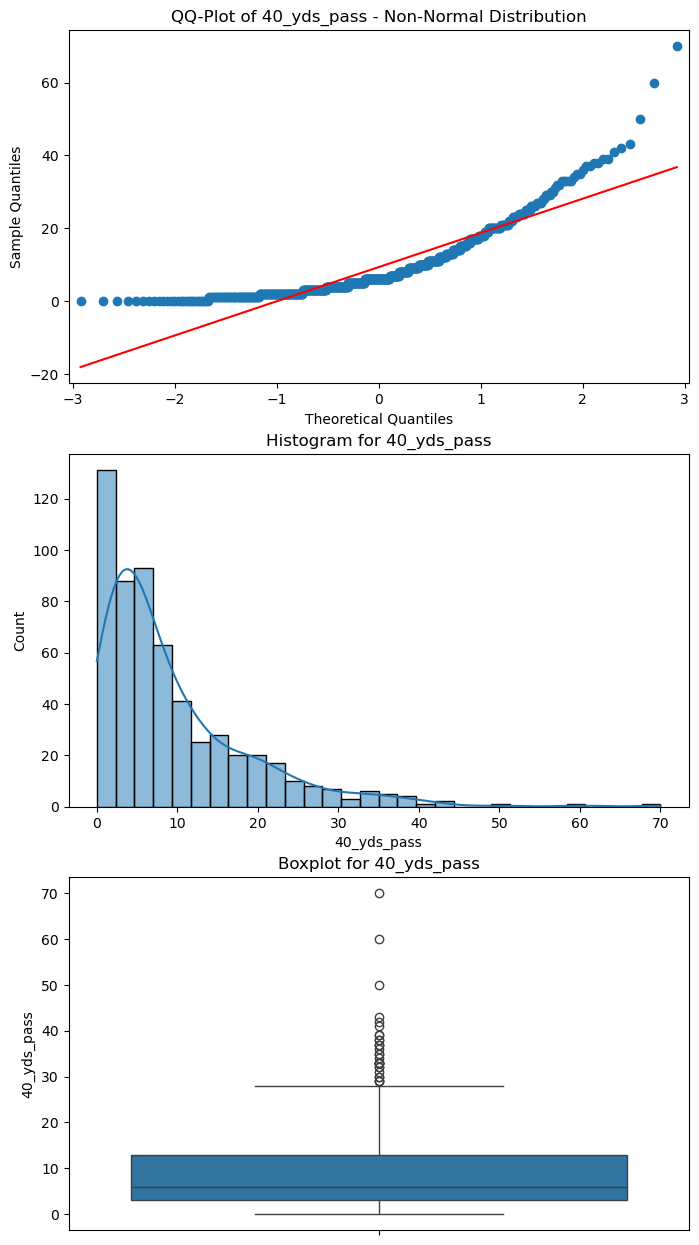

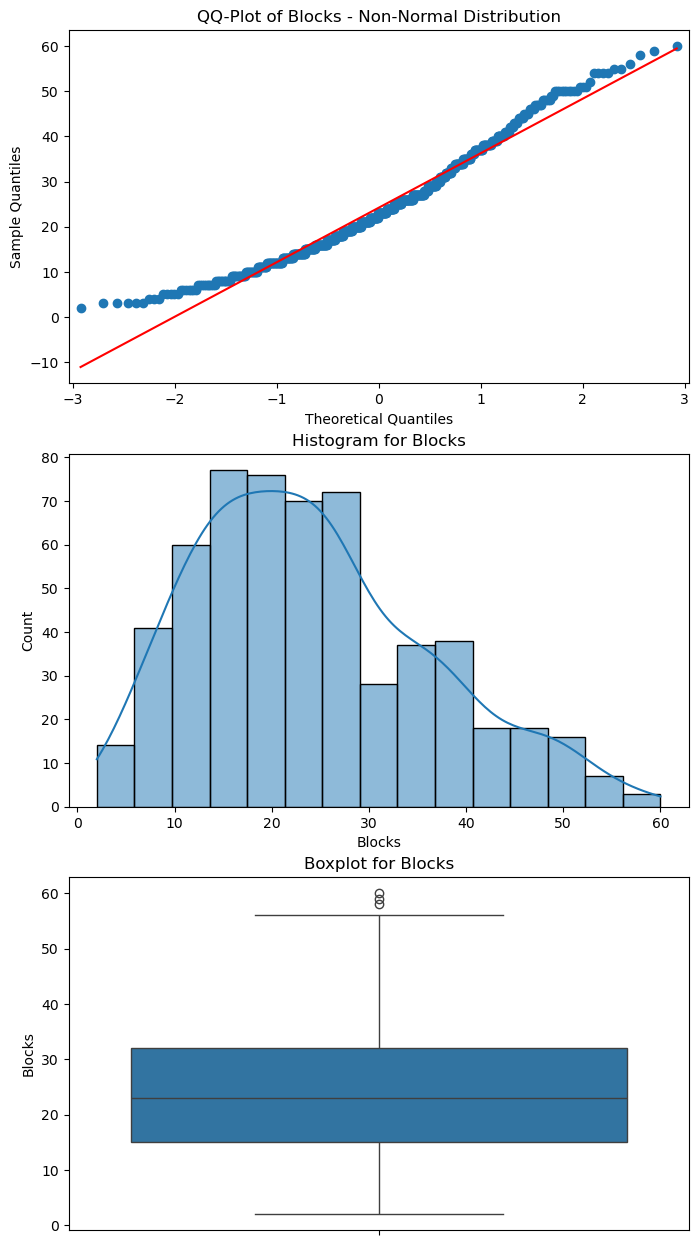

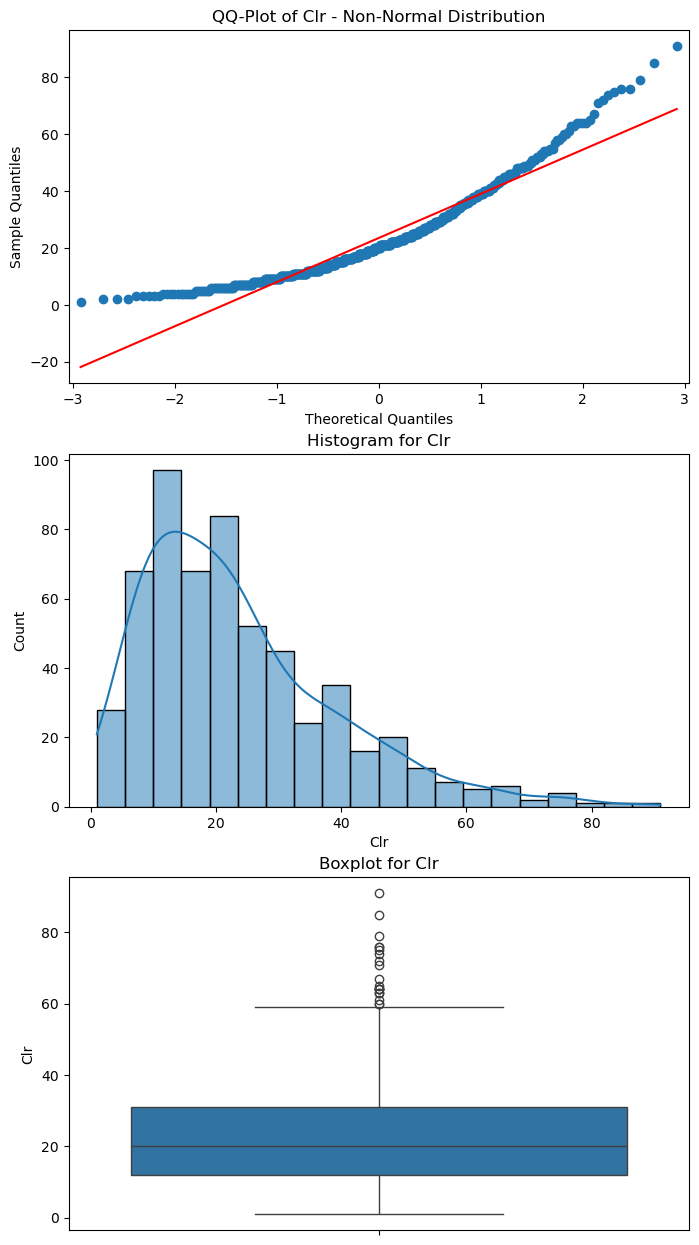

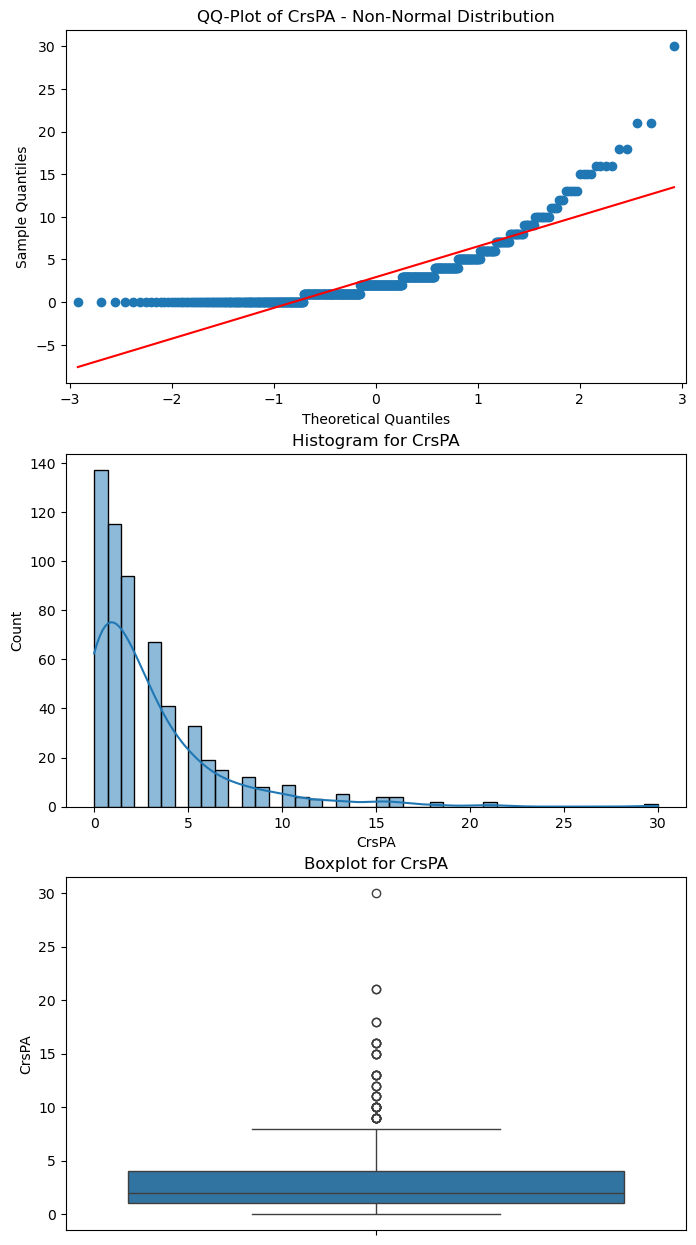

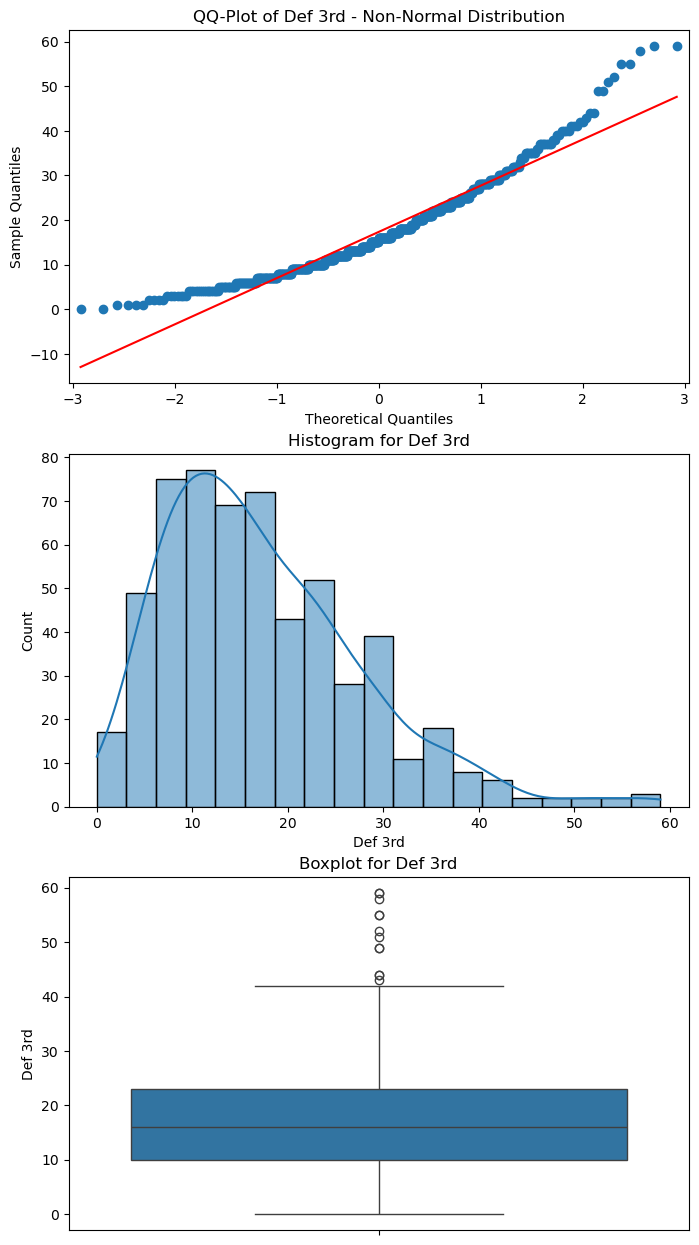

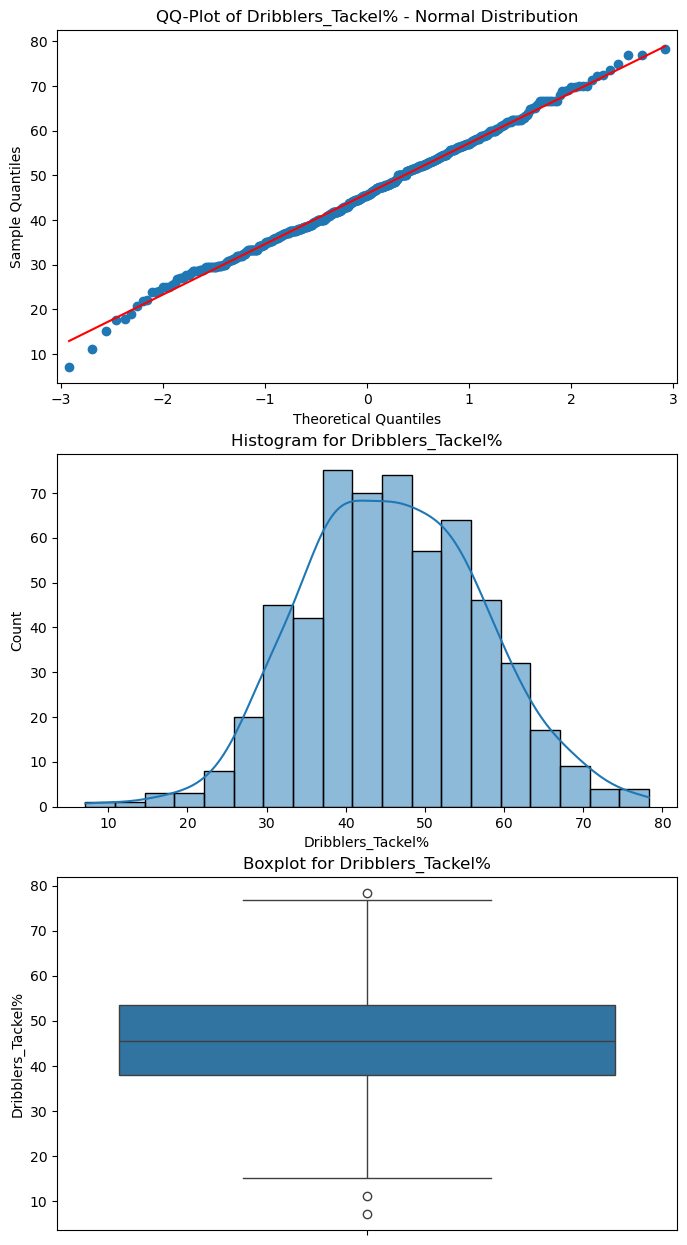

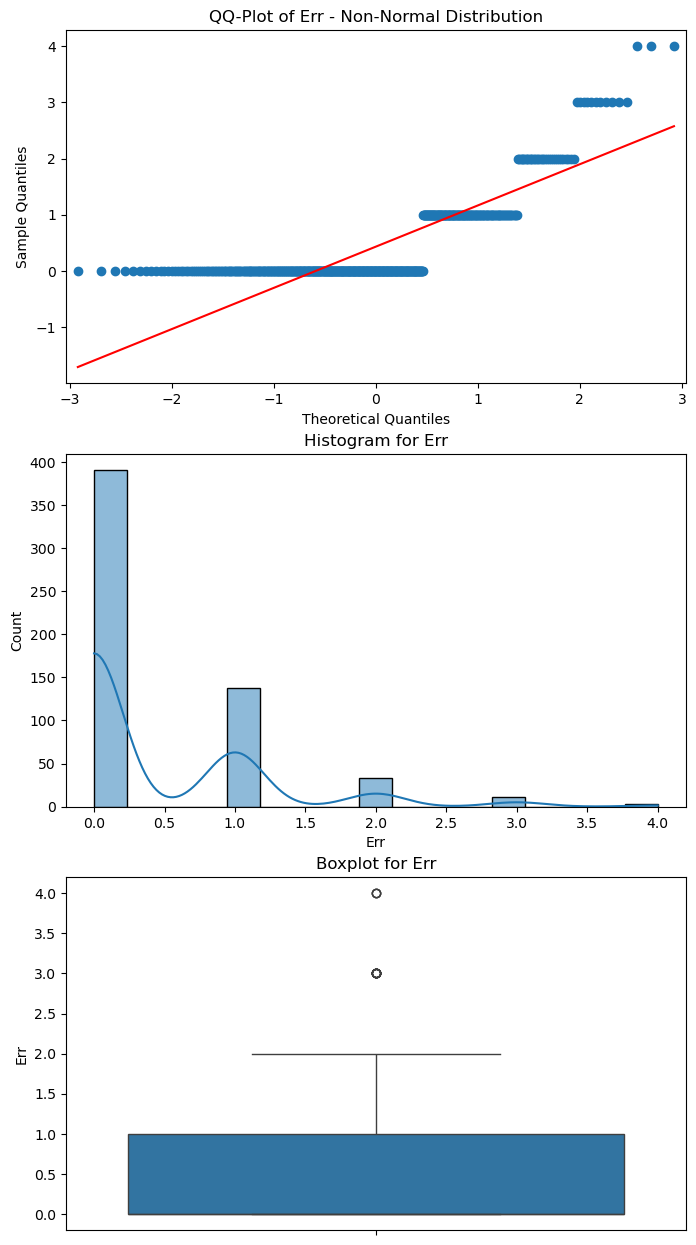

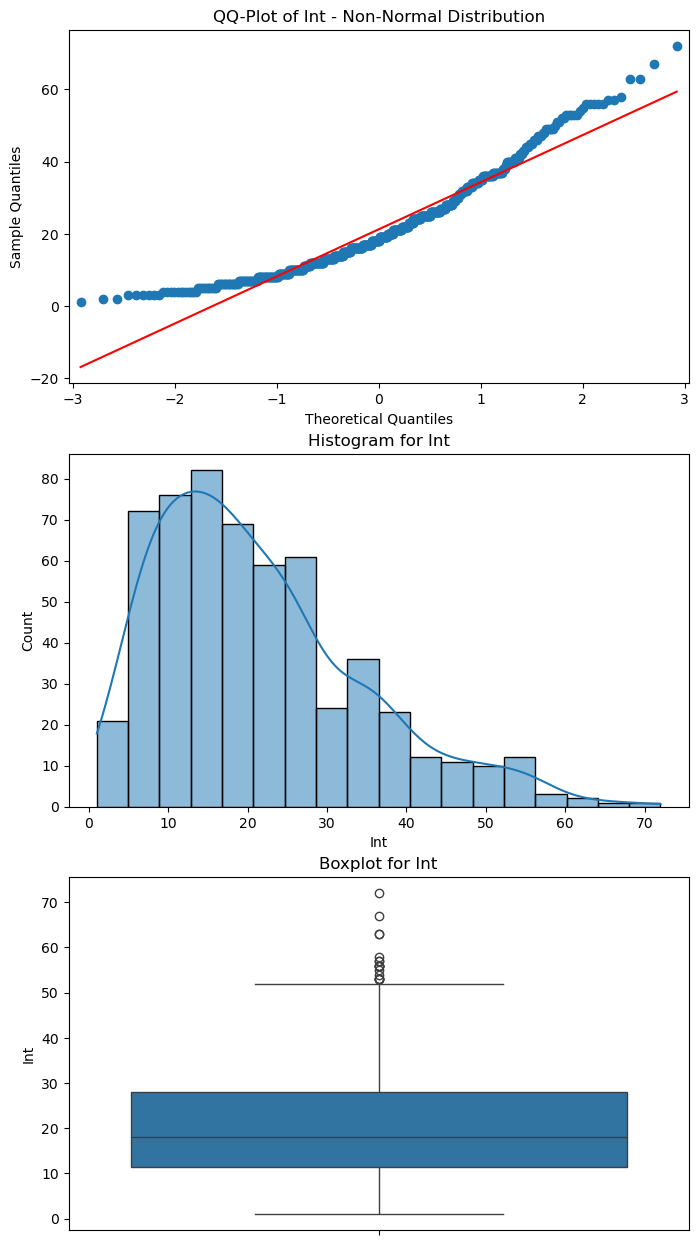

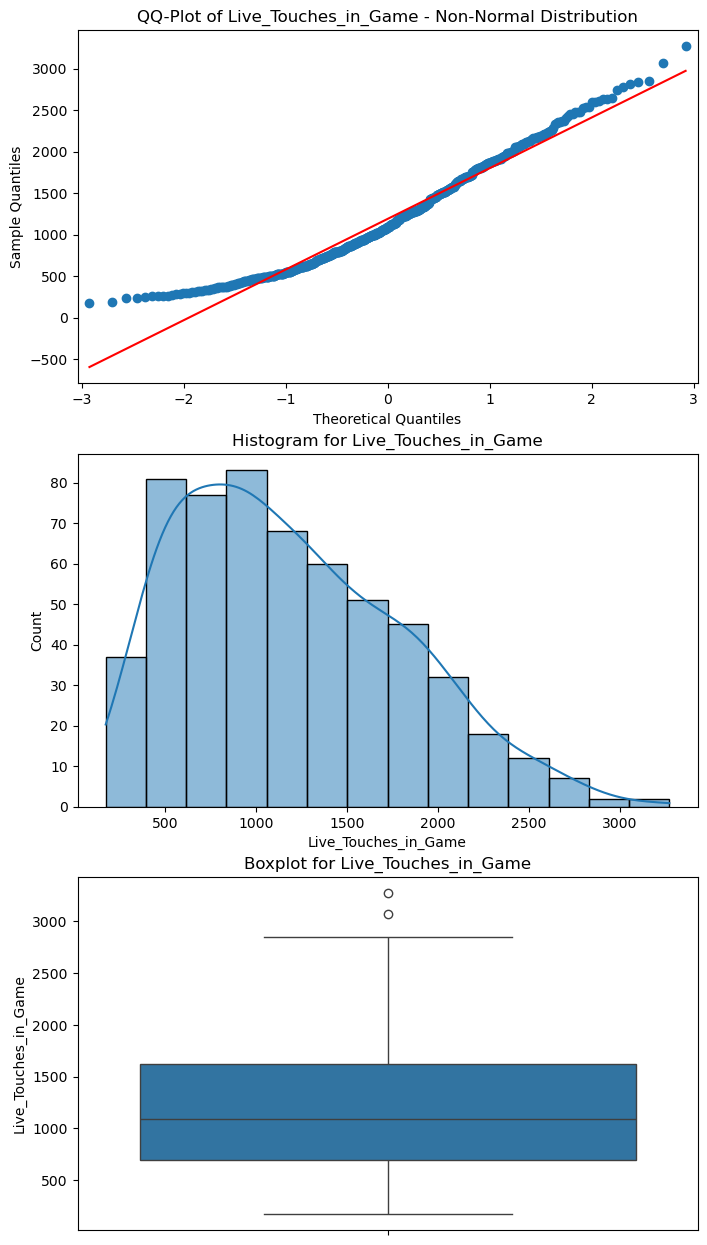

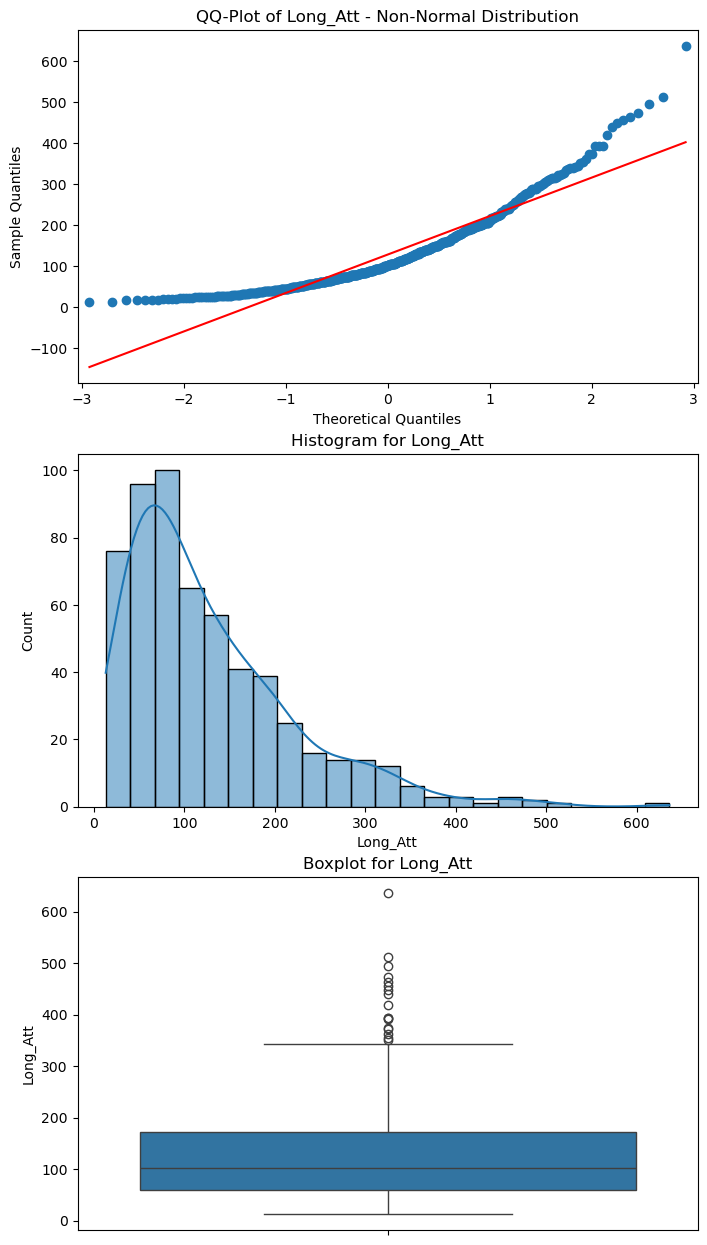

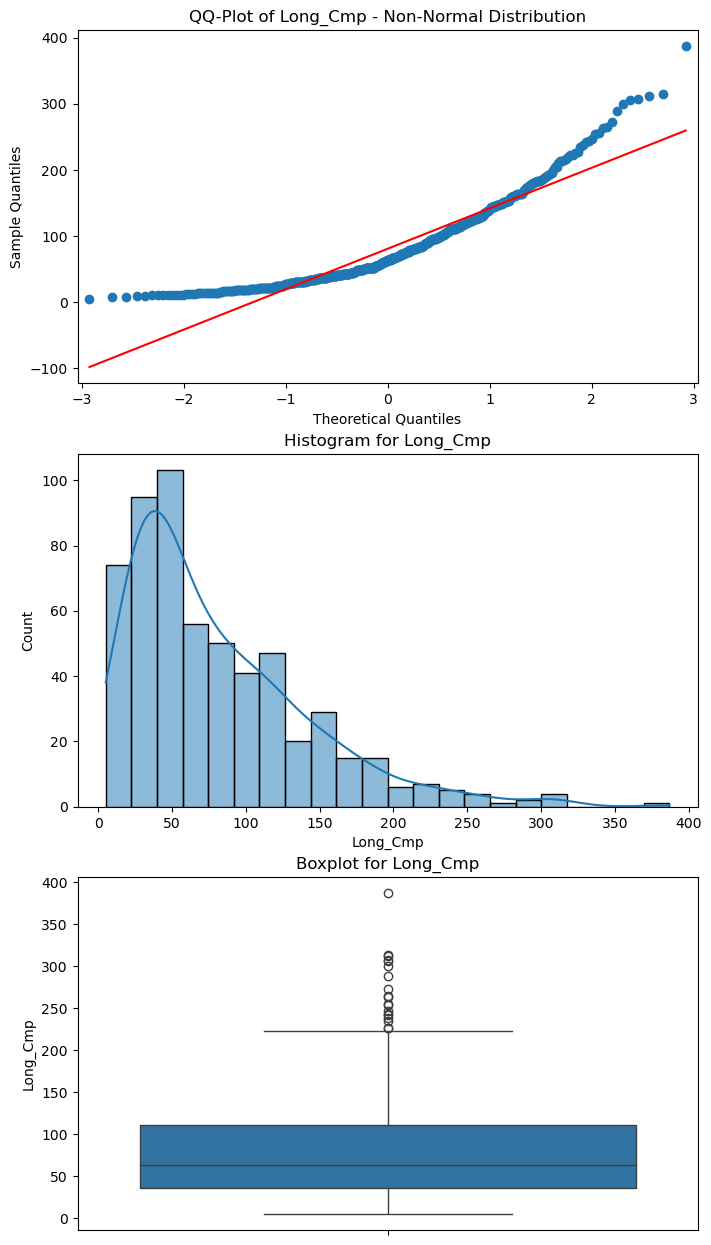

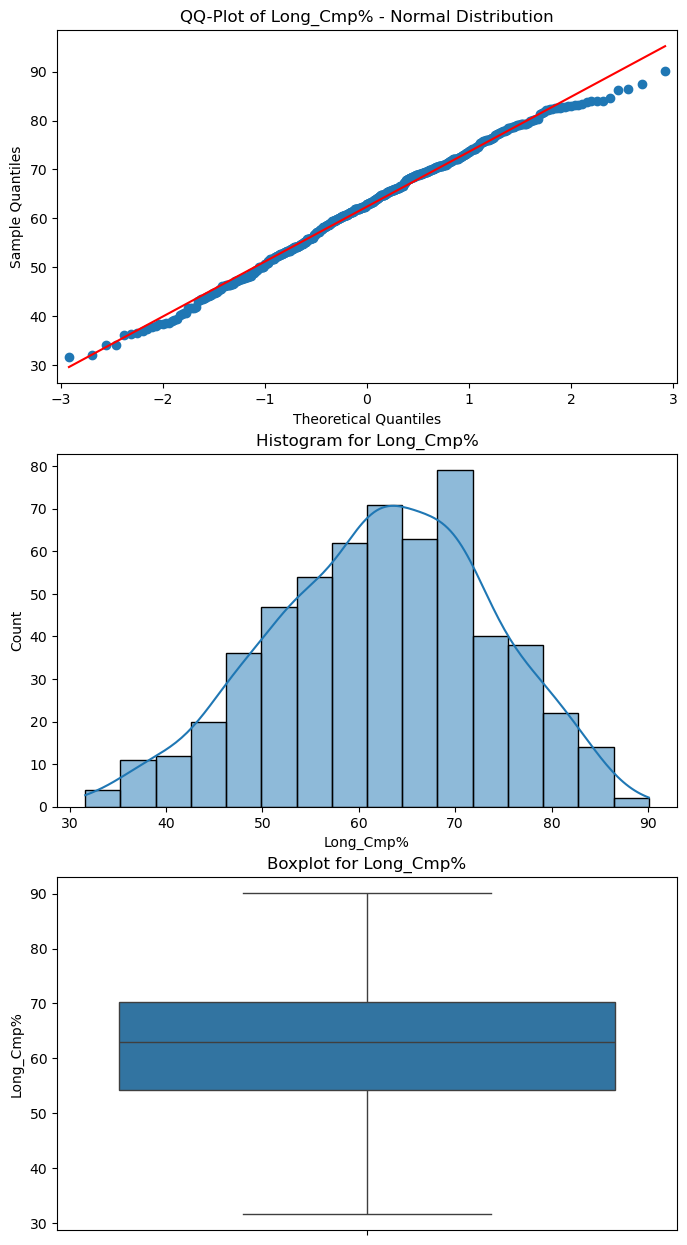

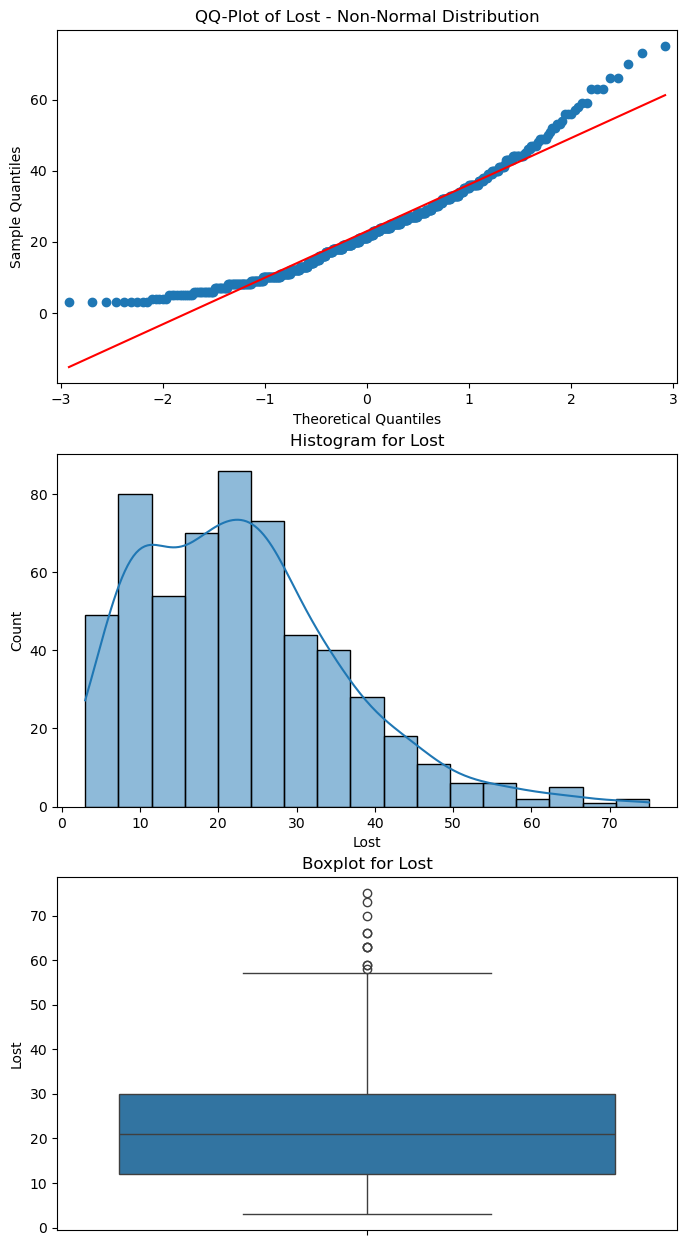

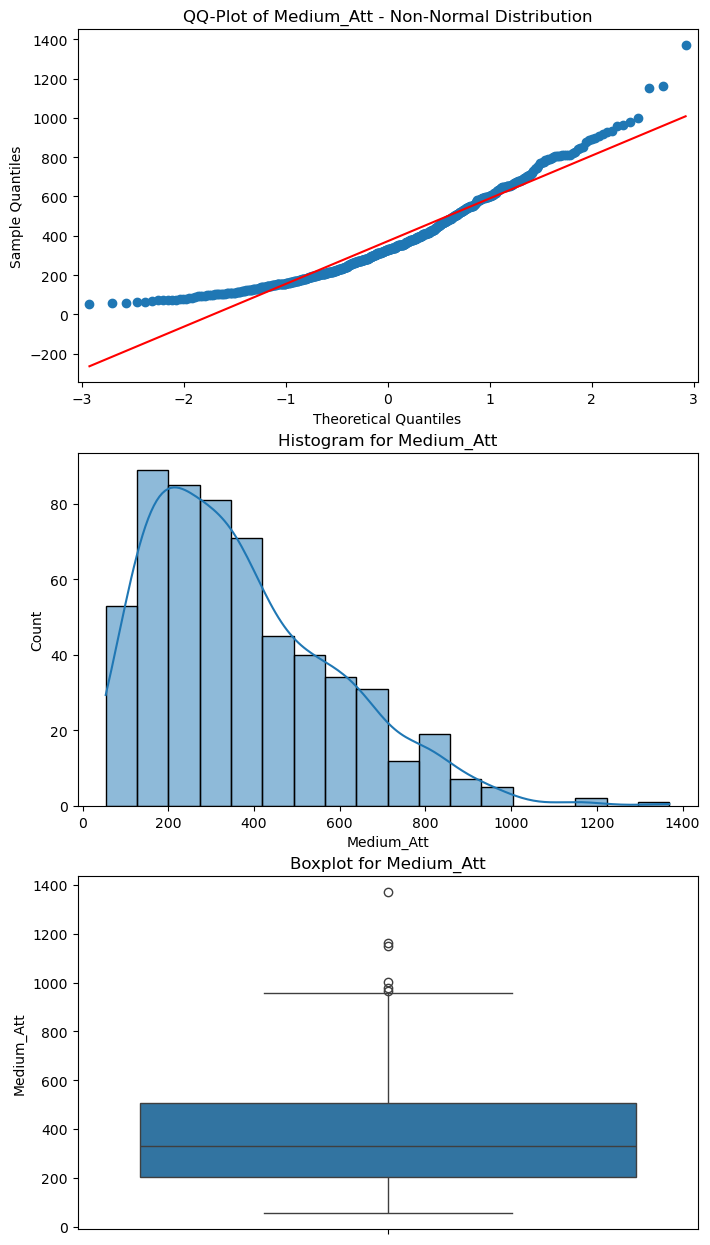

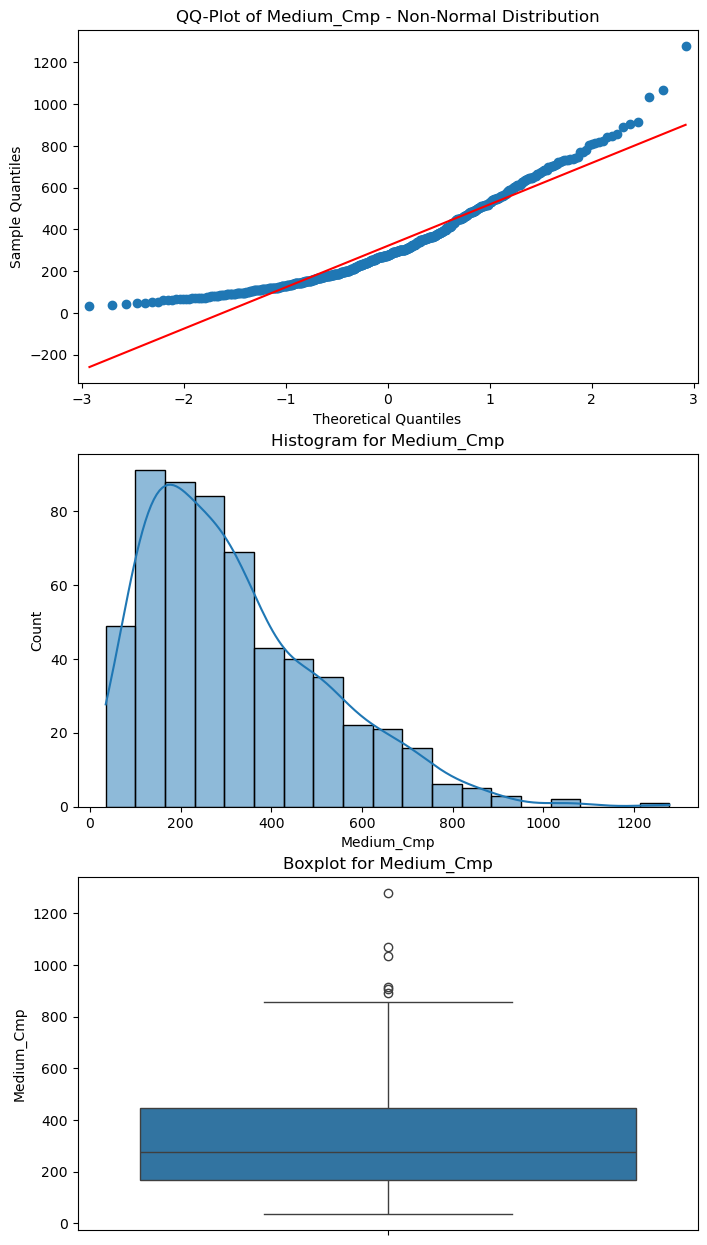

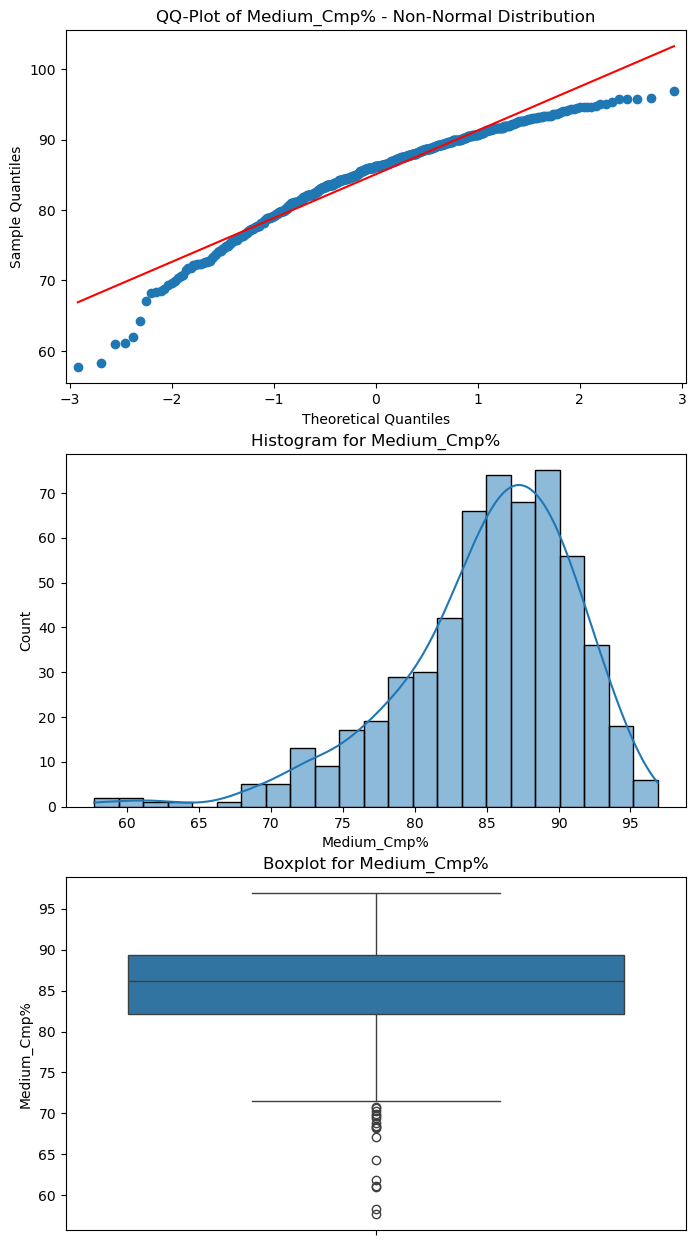

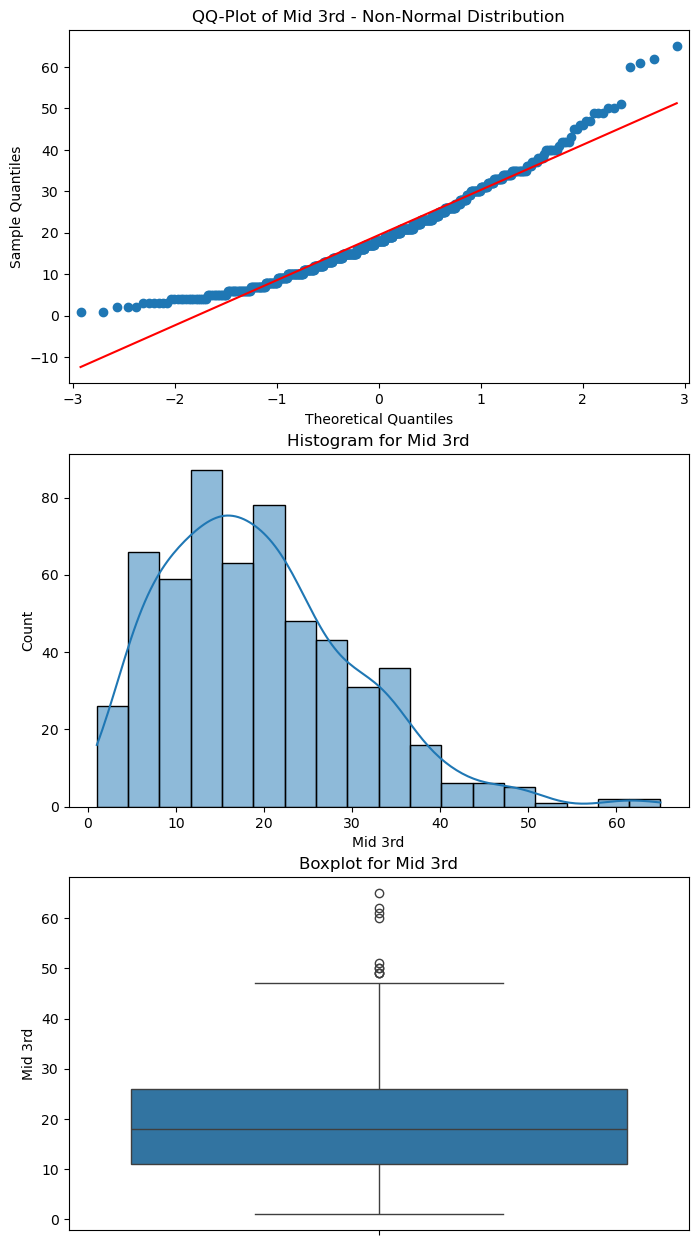

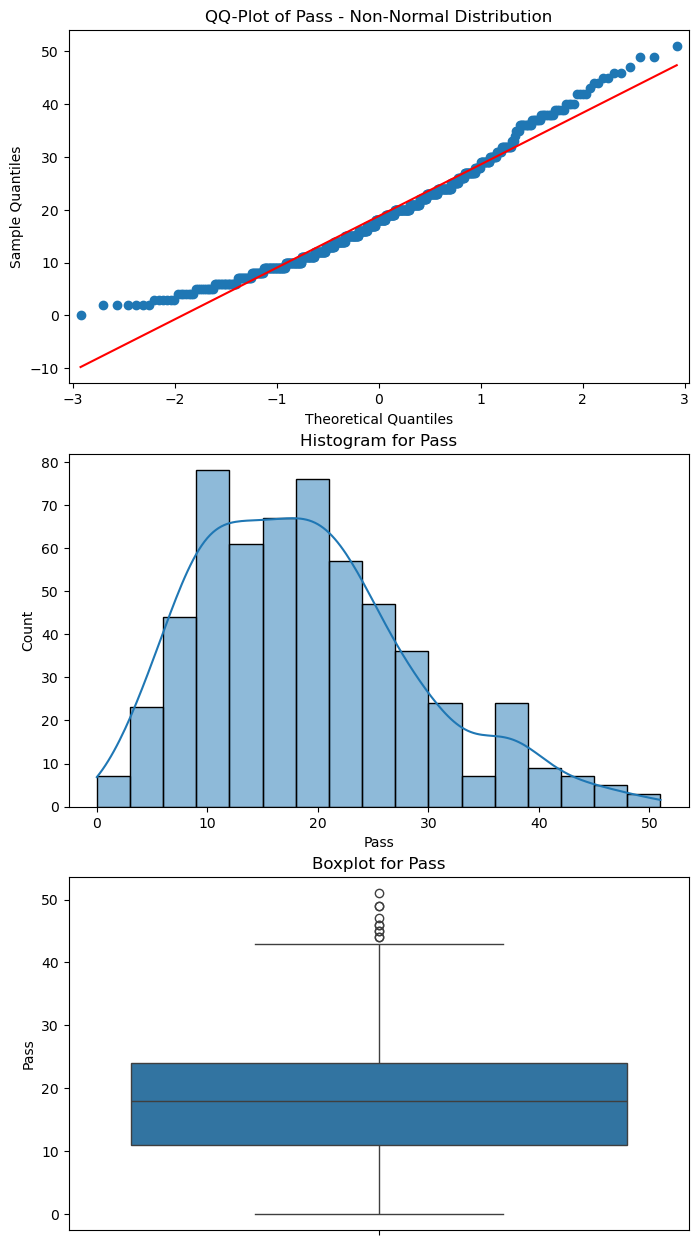

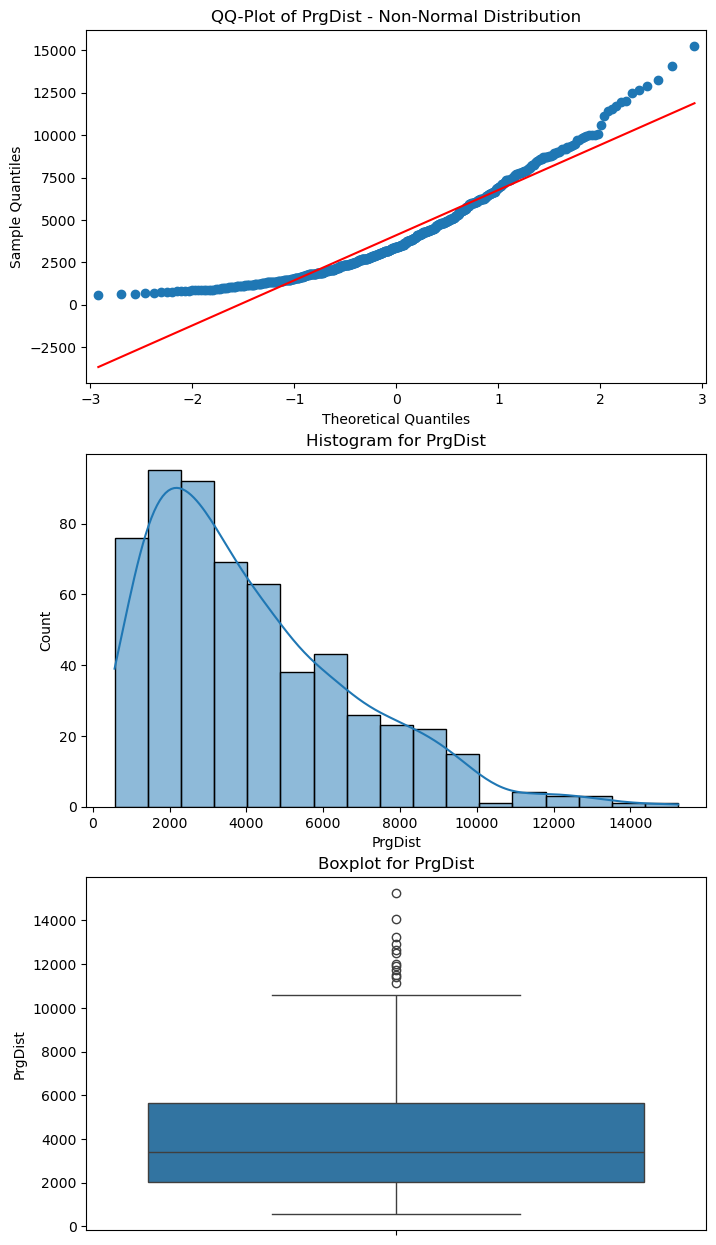

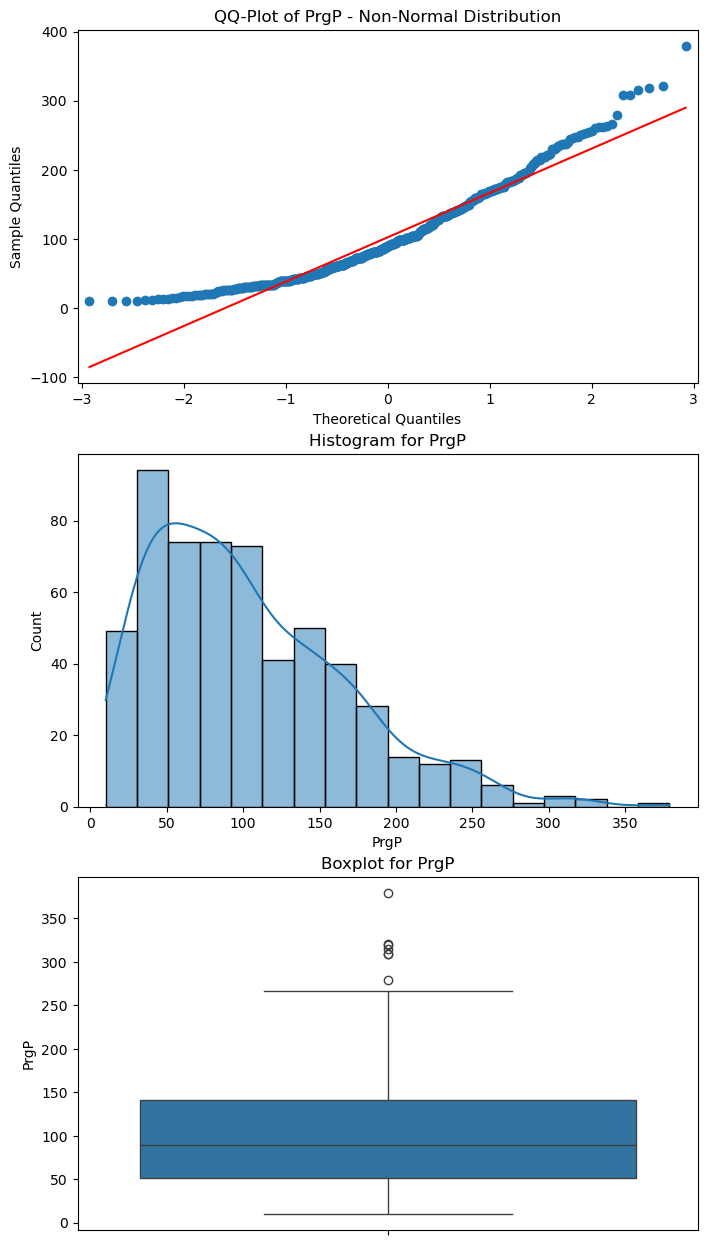

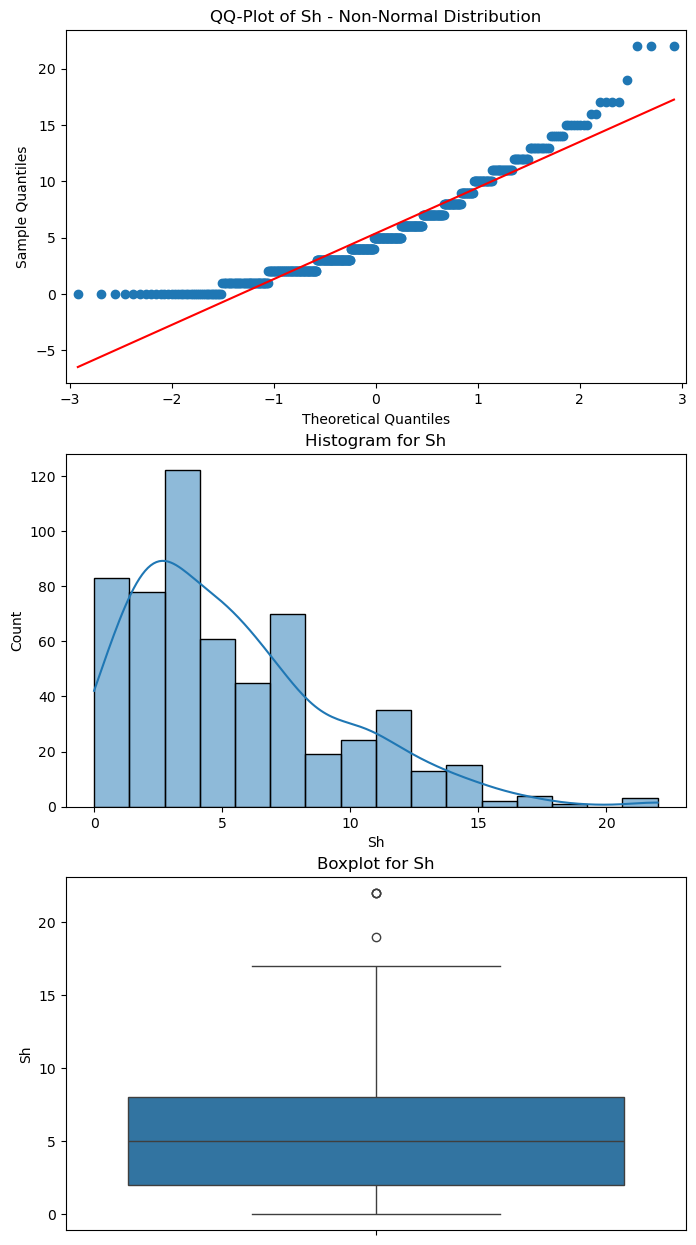

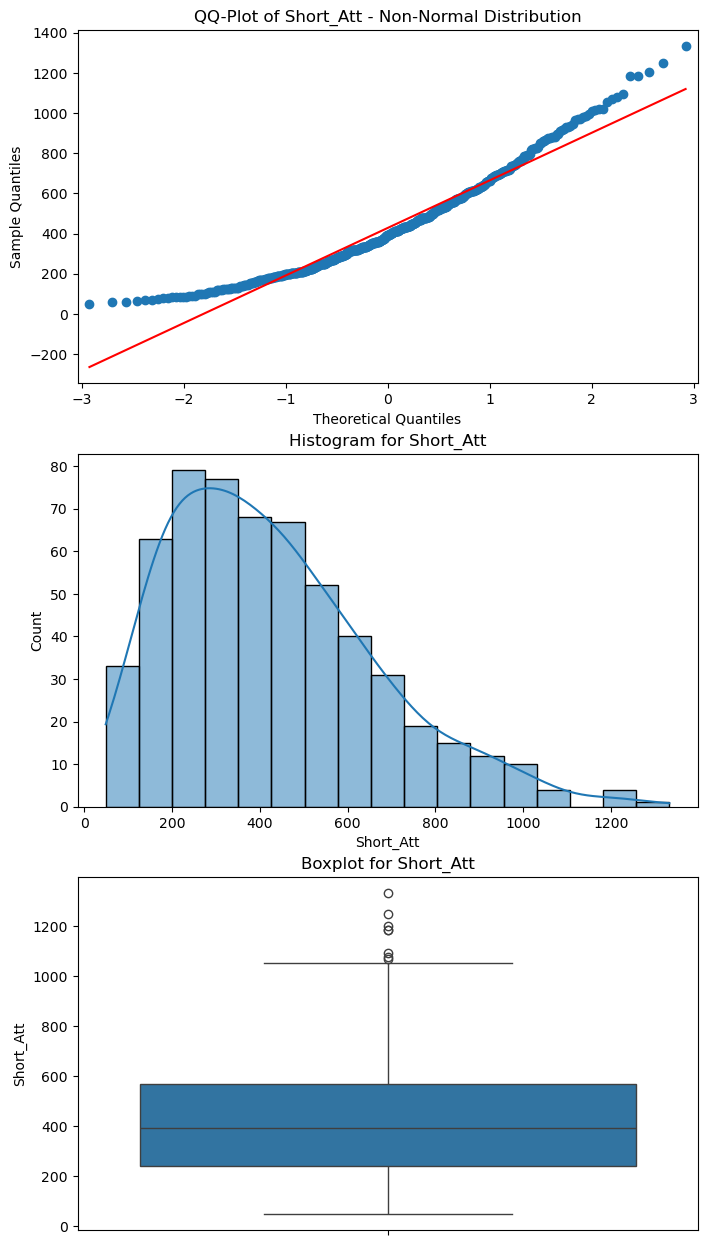

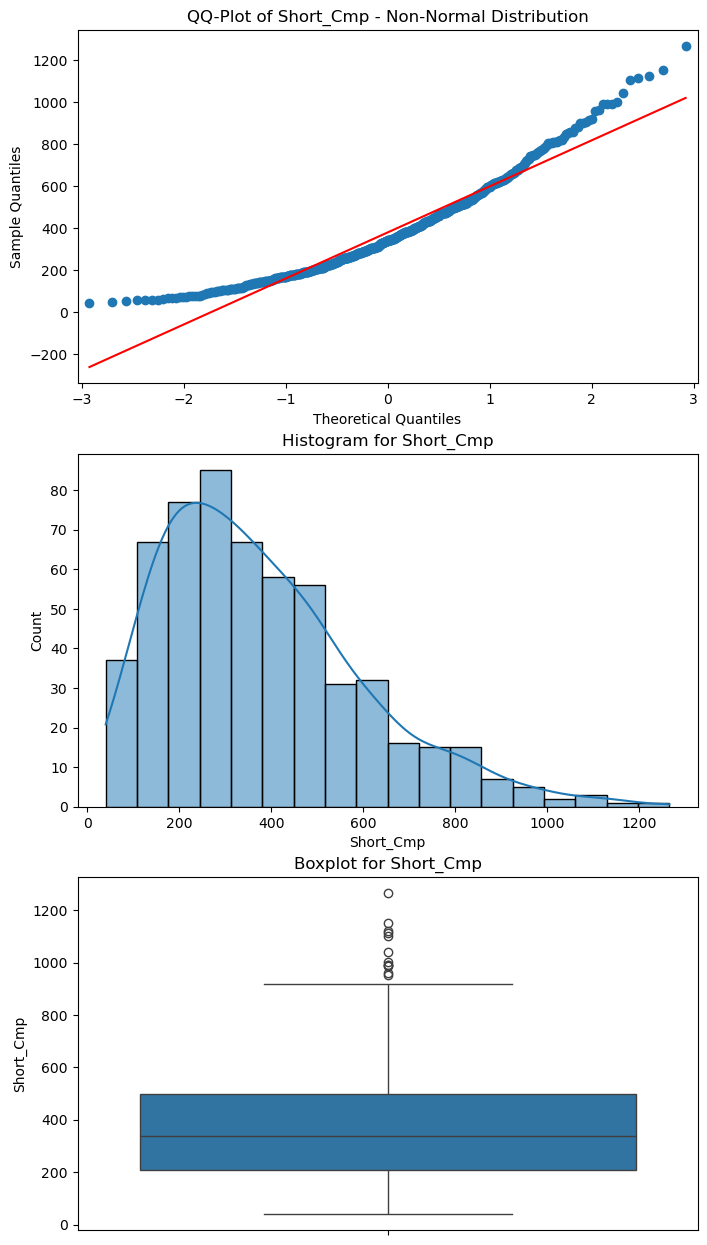

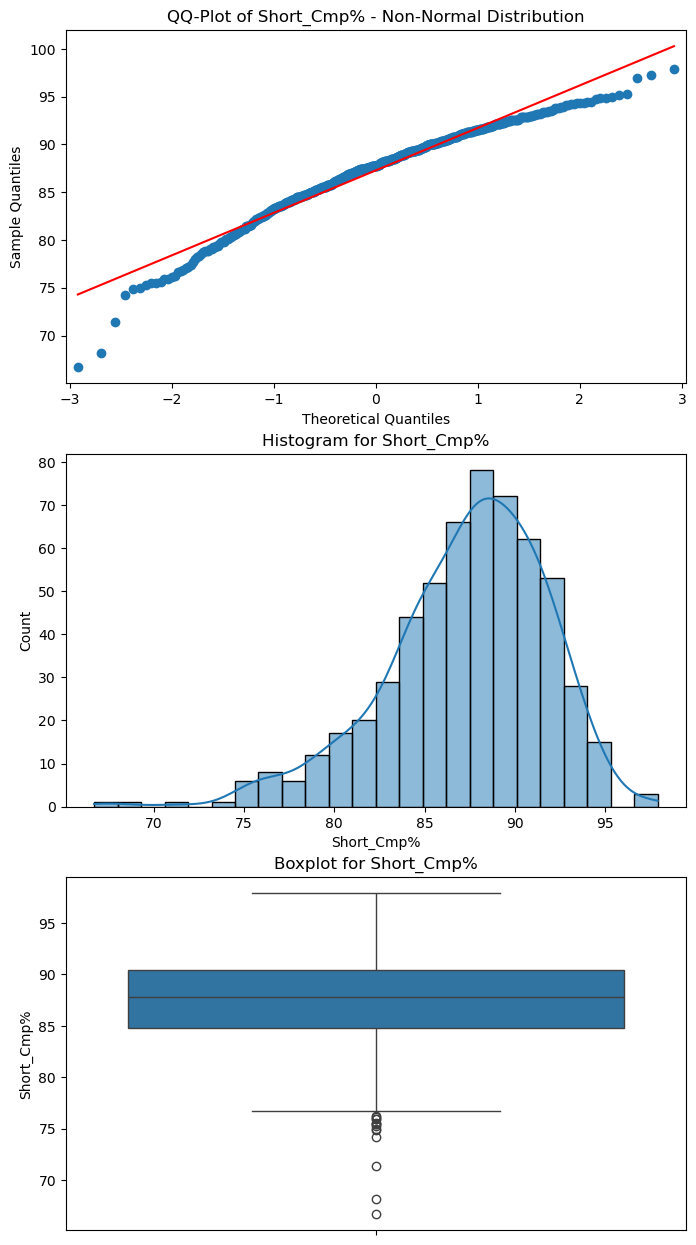

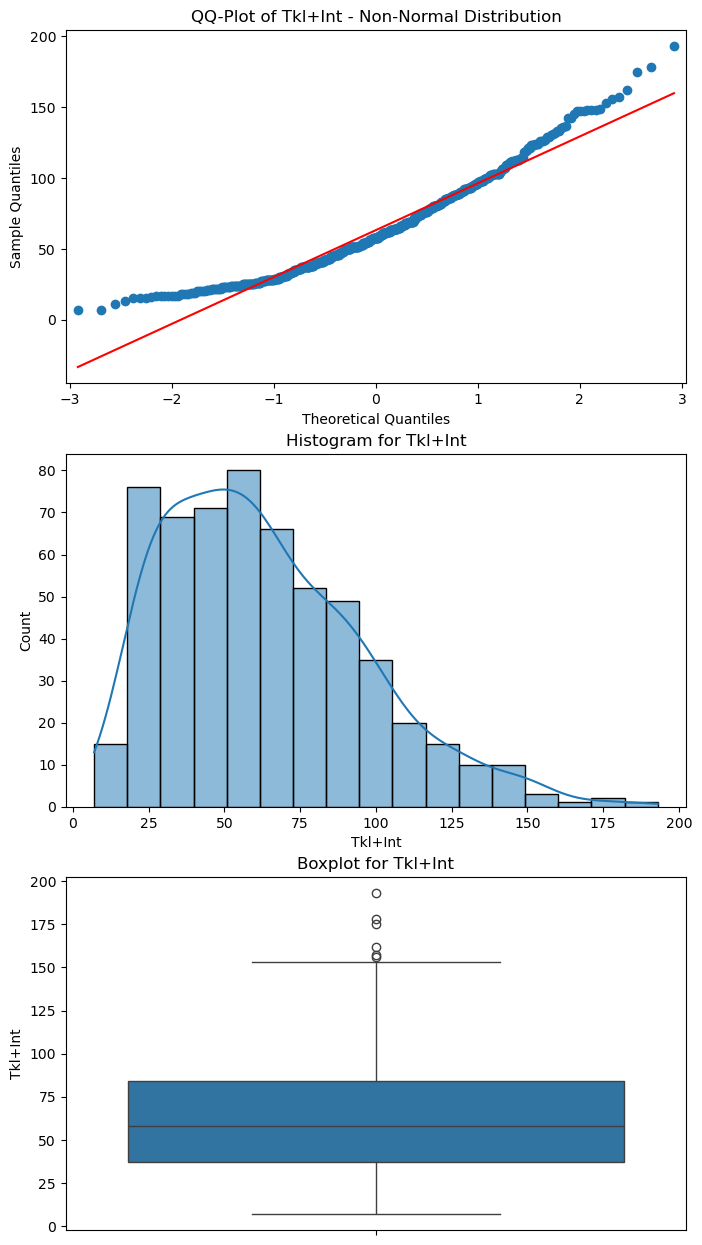

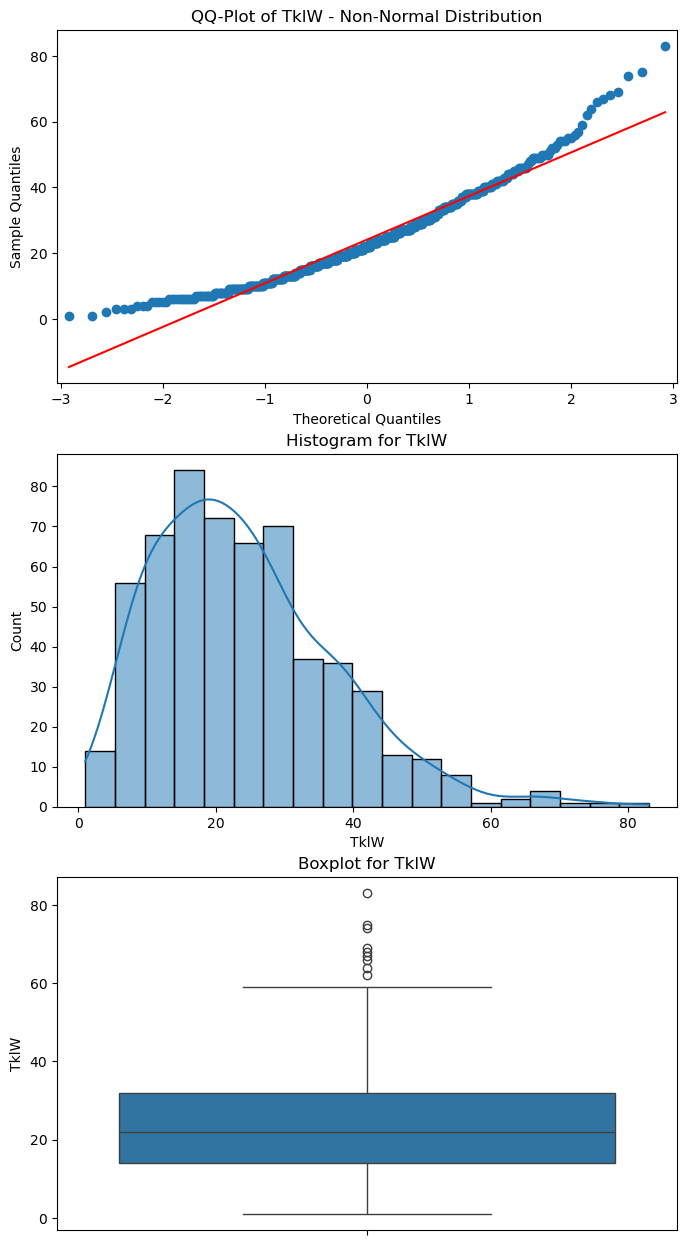

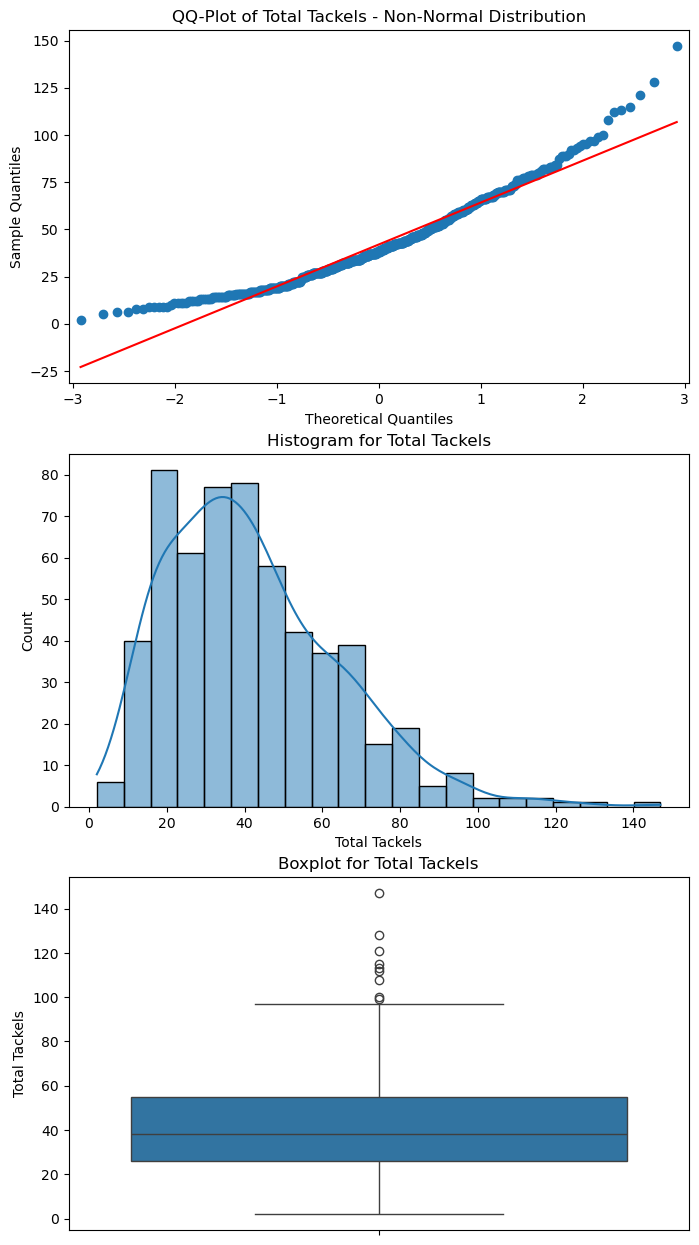

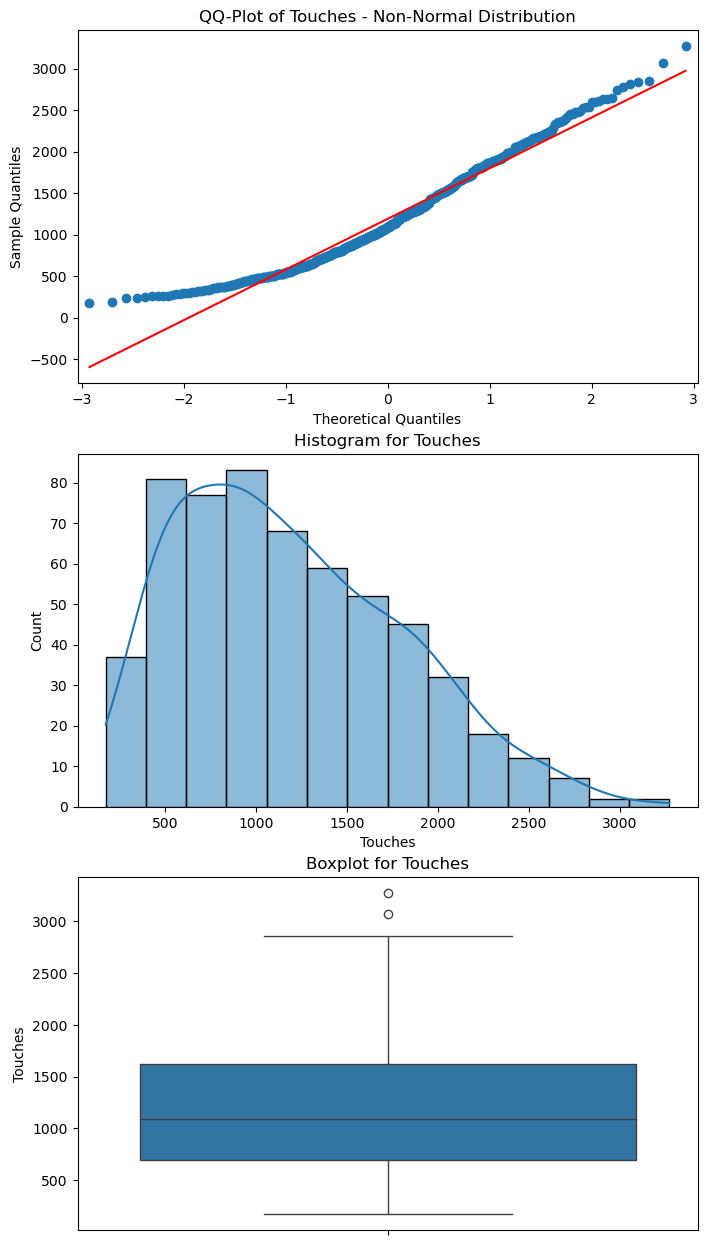

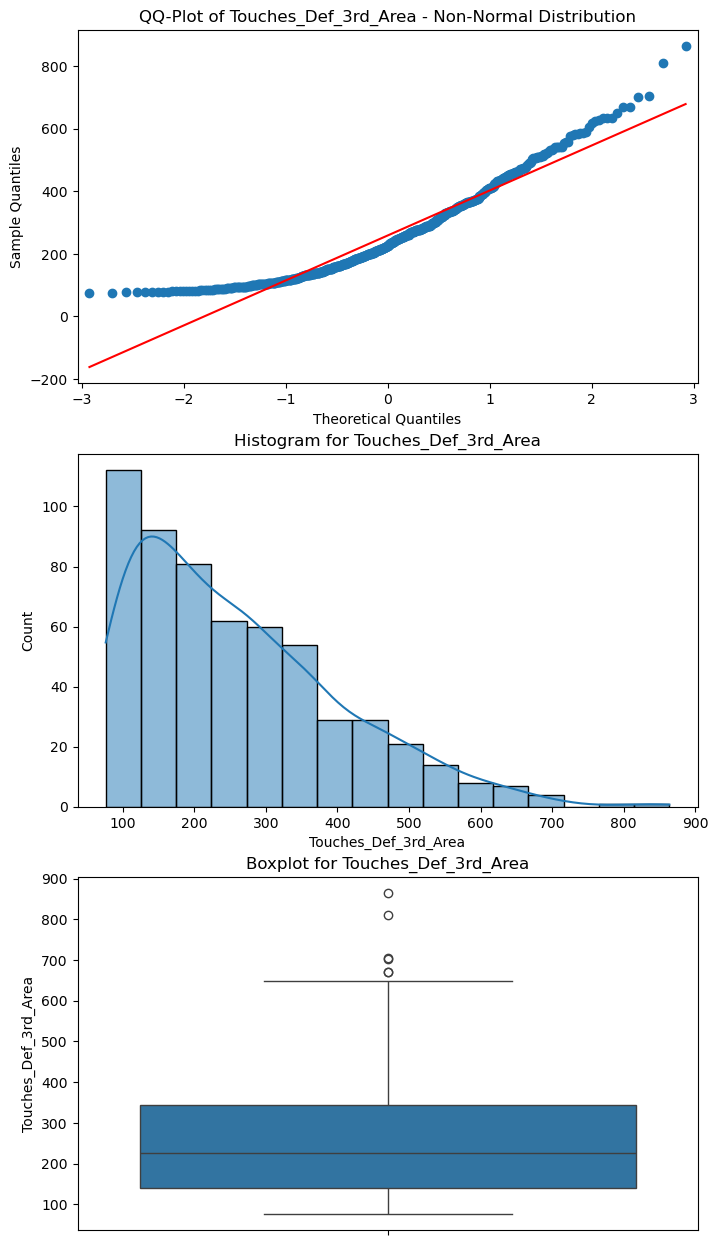

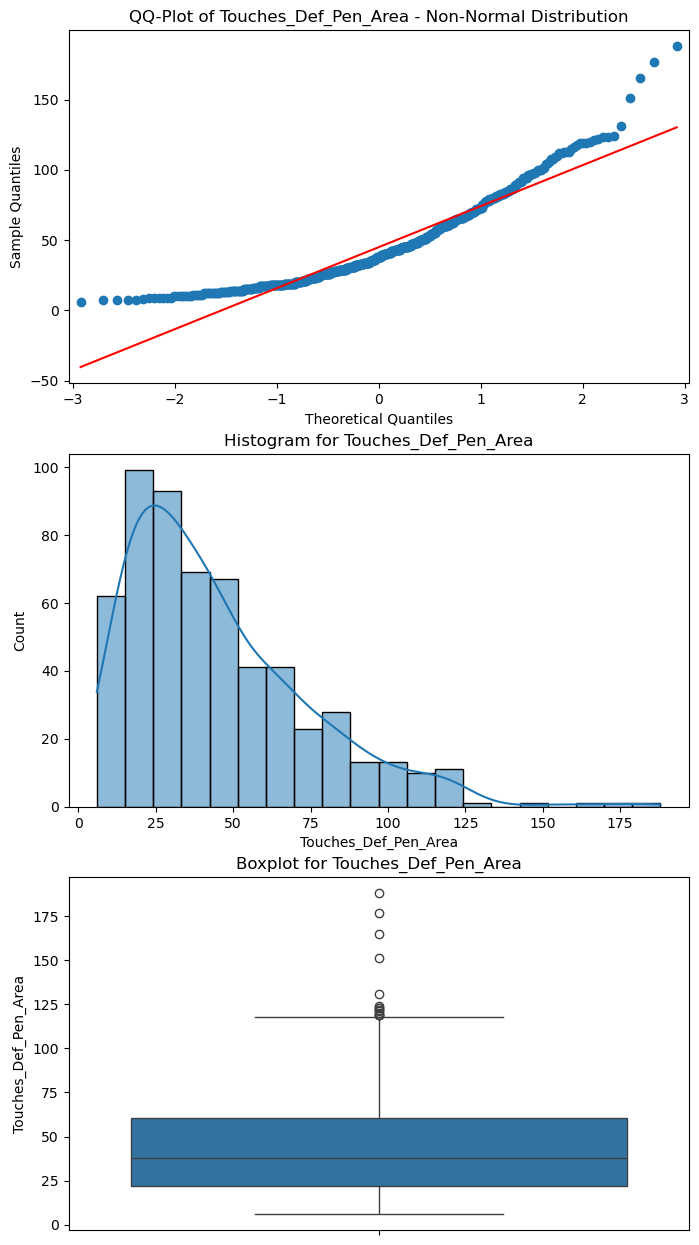

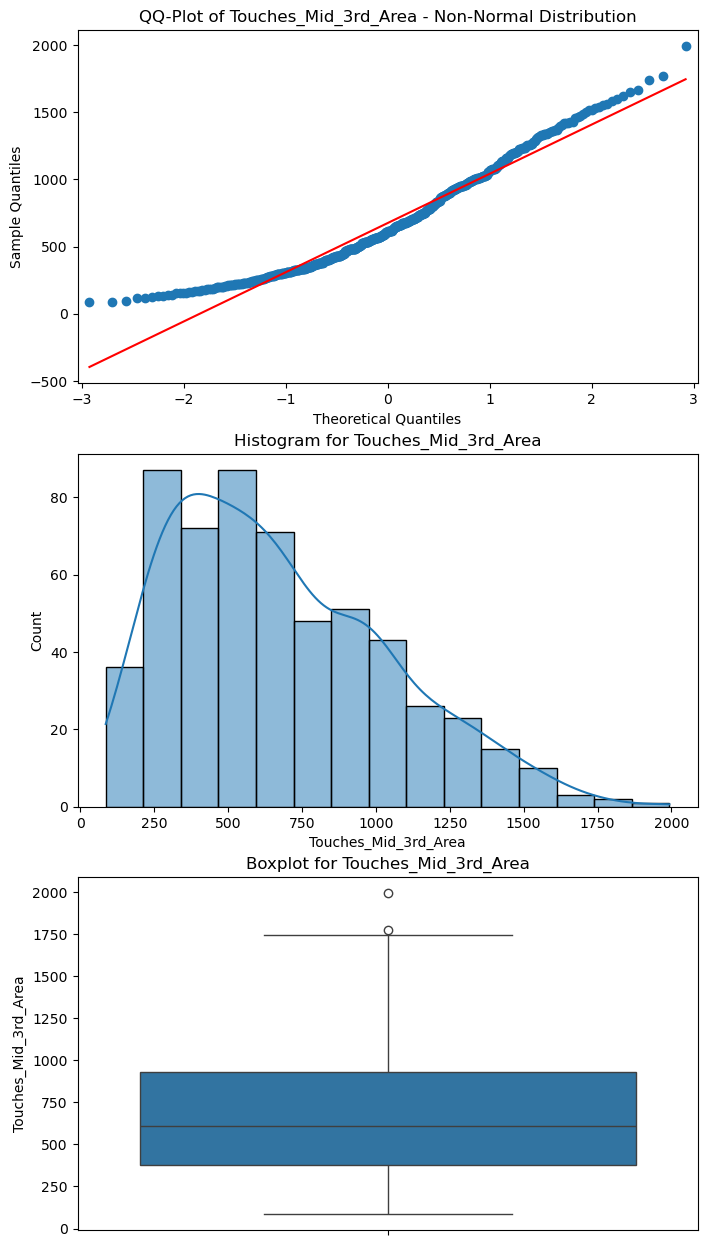

In [5]:
x_features=df_mf_.columns
for i,x in enumerate(x_features):
    fig,axes=plt.subplots(3,1,figsize=(8,6))
    plt.subplots_adjust(top=2.0,bottom=0.0)
    sm.qqplot(df_mf_[x],line='s',ax=axes[0])
    standardized_tack=(df_mf_[x]-df_mf_[x].mean())/df_mf_[x].std()
    k,p=kstest(standardized_tack,'norm')
    axes[0].set_title(f'QQ-Plot of {x} - {"Non-Normal Distribution"if float(p) < 0.05 else "Normal Distribution"}')

    sns.histplot(df_mf_[x],kde=True,bins='fd',ax=axes[1])
    axes[1].set_title(f'Histogram for {x}')
    
    sns.boxplot(df_mf_[x],ax=axes[2])
    axes[2].set_title(f'Boxplot for {x}')

With the exception of two features, none of the other features follow a normal distribution, which makes it easier to test the correlation levels. Most of the feature distributions are skewed to the right, so we are dealing with outliers. We will keep them because we want to find the best six for Bayern Munich. The next step is feature selection, which we will do using the correlation and variance levels.

### Feature selection
In this step we will select the most important features based on their correlation and variance levels. Correlation, we will filter out the features with correlation levels between 1.0-0.8, because the features that are highly correlated with each other will not allow us to gain more information about the clusters, because when one feature goes up or down, the other will follow. It will also help us deal with multi-correlation.
After we have filtered out the highly correlated features, we will check the variance, we will filter out the low variance features. We will do this because low variance features will not help us to better understand the different clusters/groups.

#### Correlation

The majority of the data is not normally distributed, so we will use Spearmann's correlation for all the features.

Text(0.5, 1.0, 'Correlation Matrix Before Filtering')

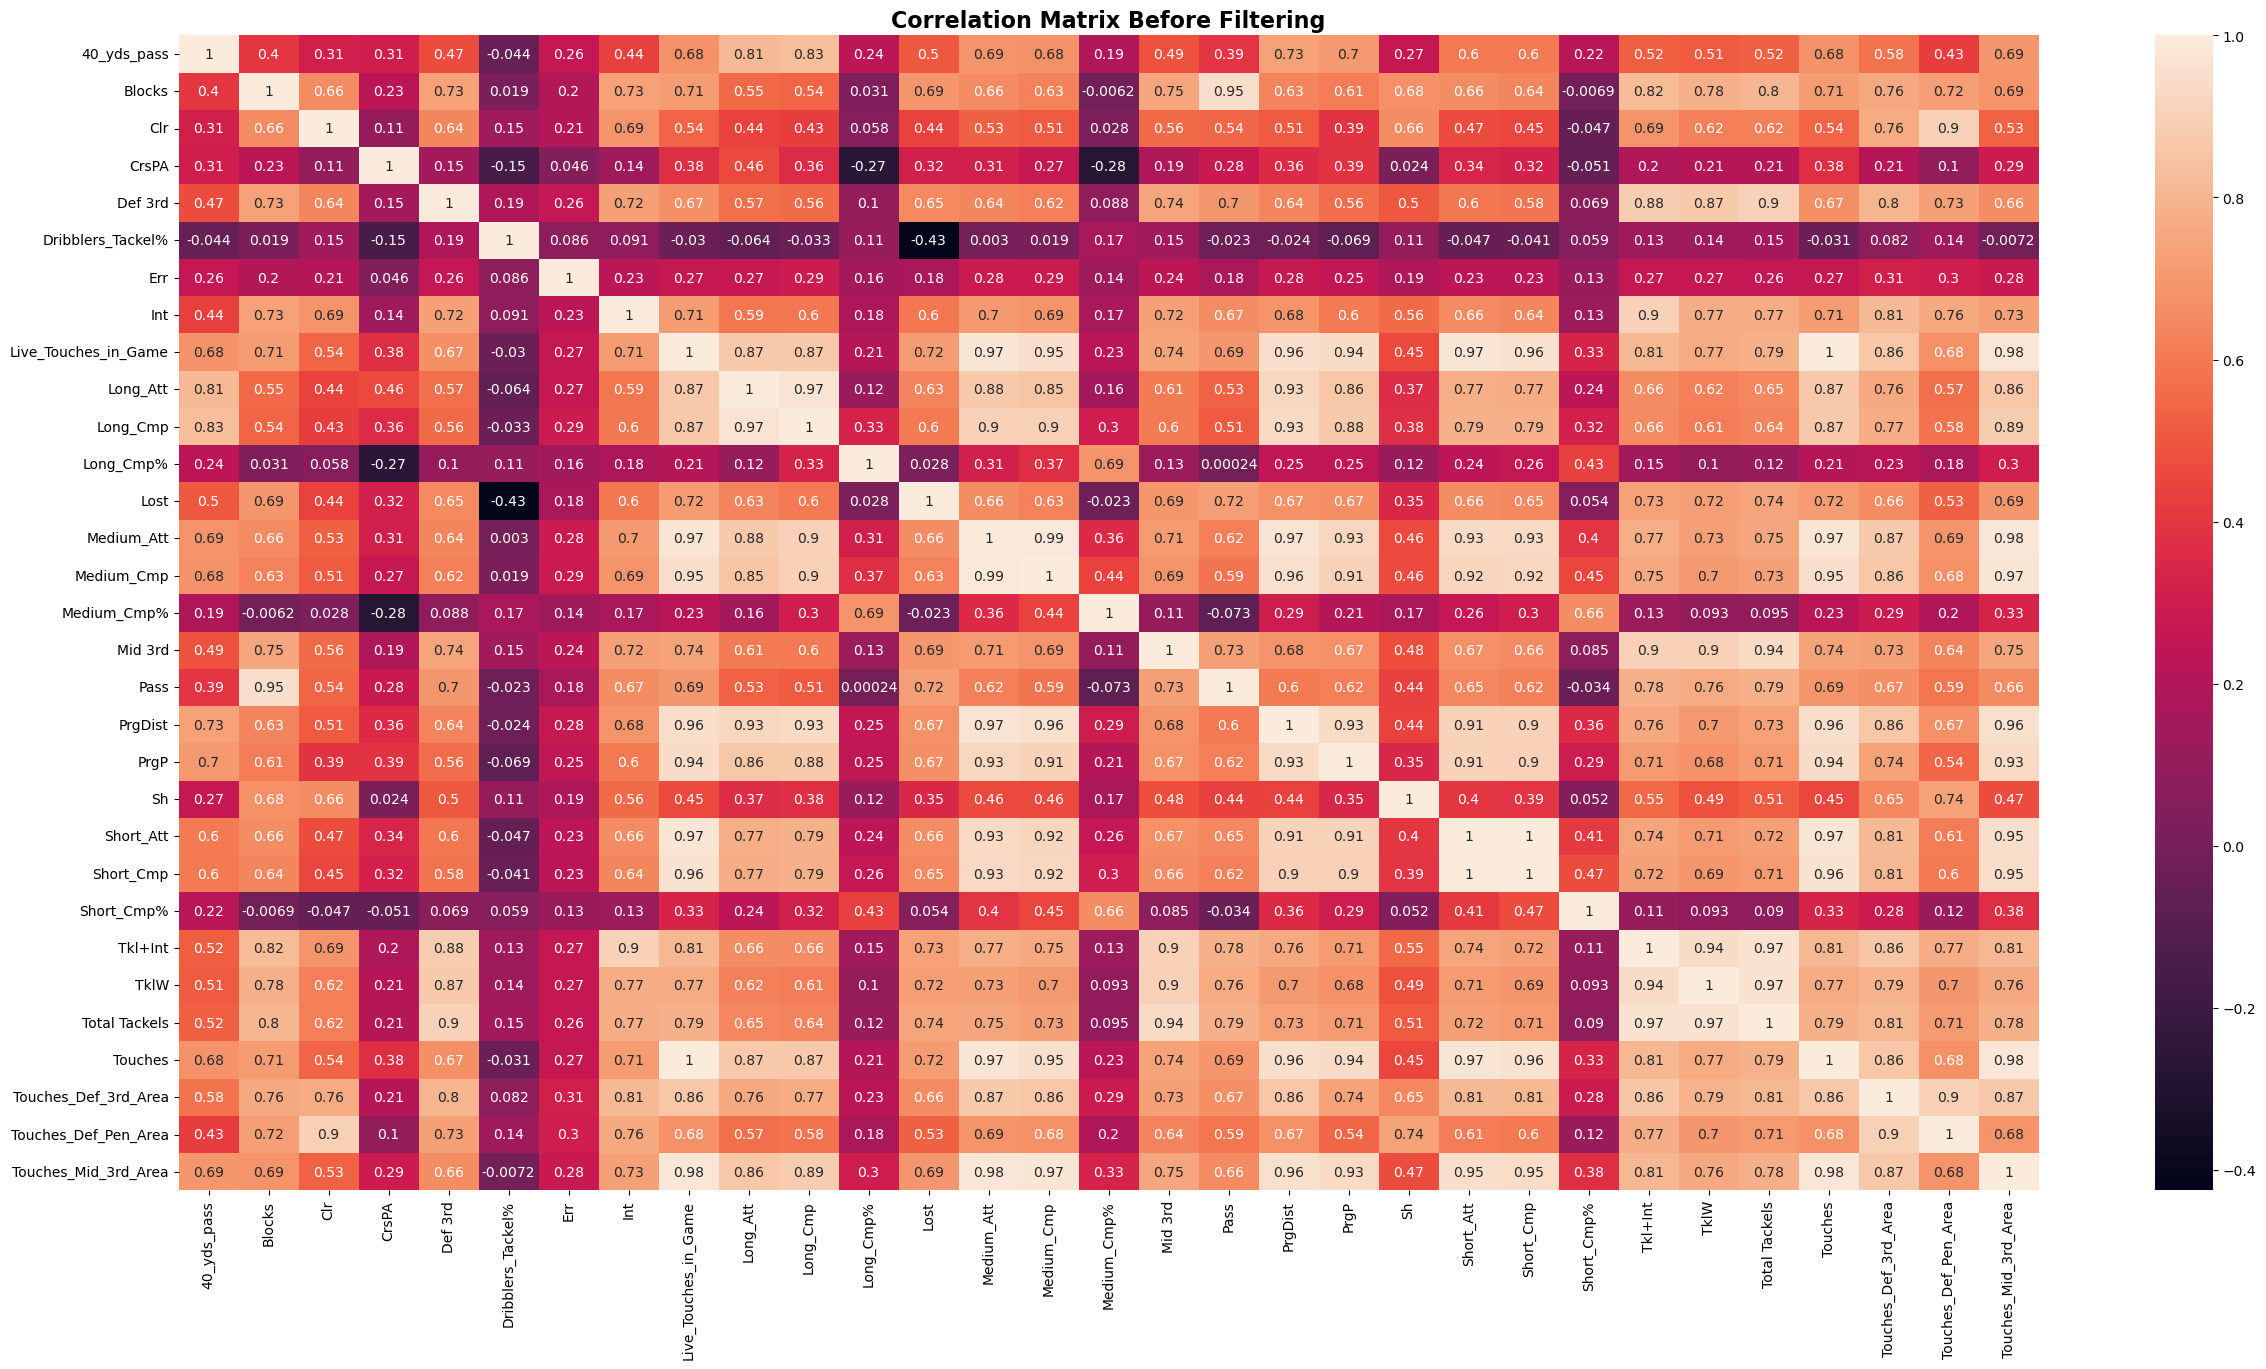

In [6]:
#prefiltered data frame
plt.figure(figsize=(30,15))
corr_matrix=df_mf_.corr(method='spearman')
threshold = 0.8
to_drop = set()  #set to store features to drop; set because it holds only unique values
#looping through all the available columns and giving a it a numerical value
for i in range(len(corr_matrix.columns)):
    #based on the i value it will create a new range; due to the range logic i and j will never be the same value
    ## example i=3; j = [0,1,2]
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # If correlation is higher than threshold, drop i-feature from the pair
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

df_filtered = df_mf_.drop(columns=to_drop)
sns.heatmap(corr_matrix,annot=True)
plt.title('Correlation Matrix Before Filtering',size=16,fontweight='bold')

Text(0.5, 1.0, 'Correlation Matrix After Filtering')

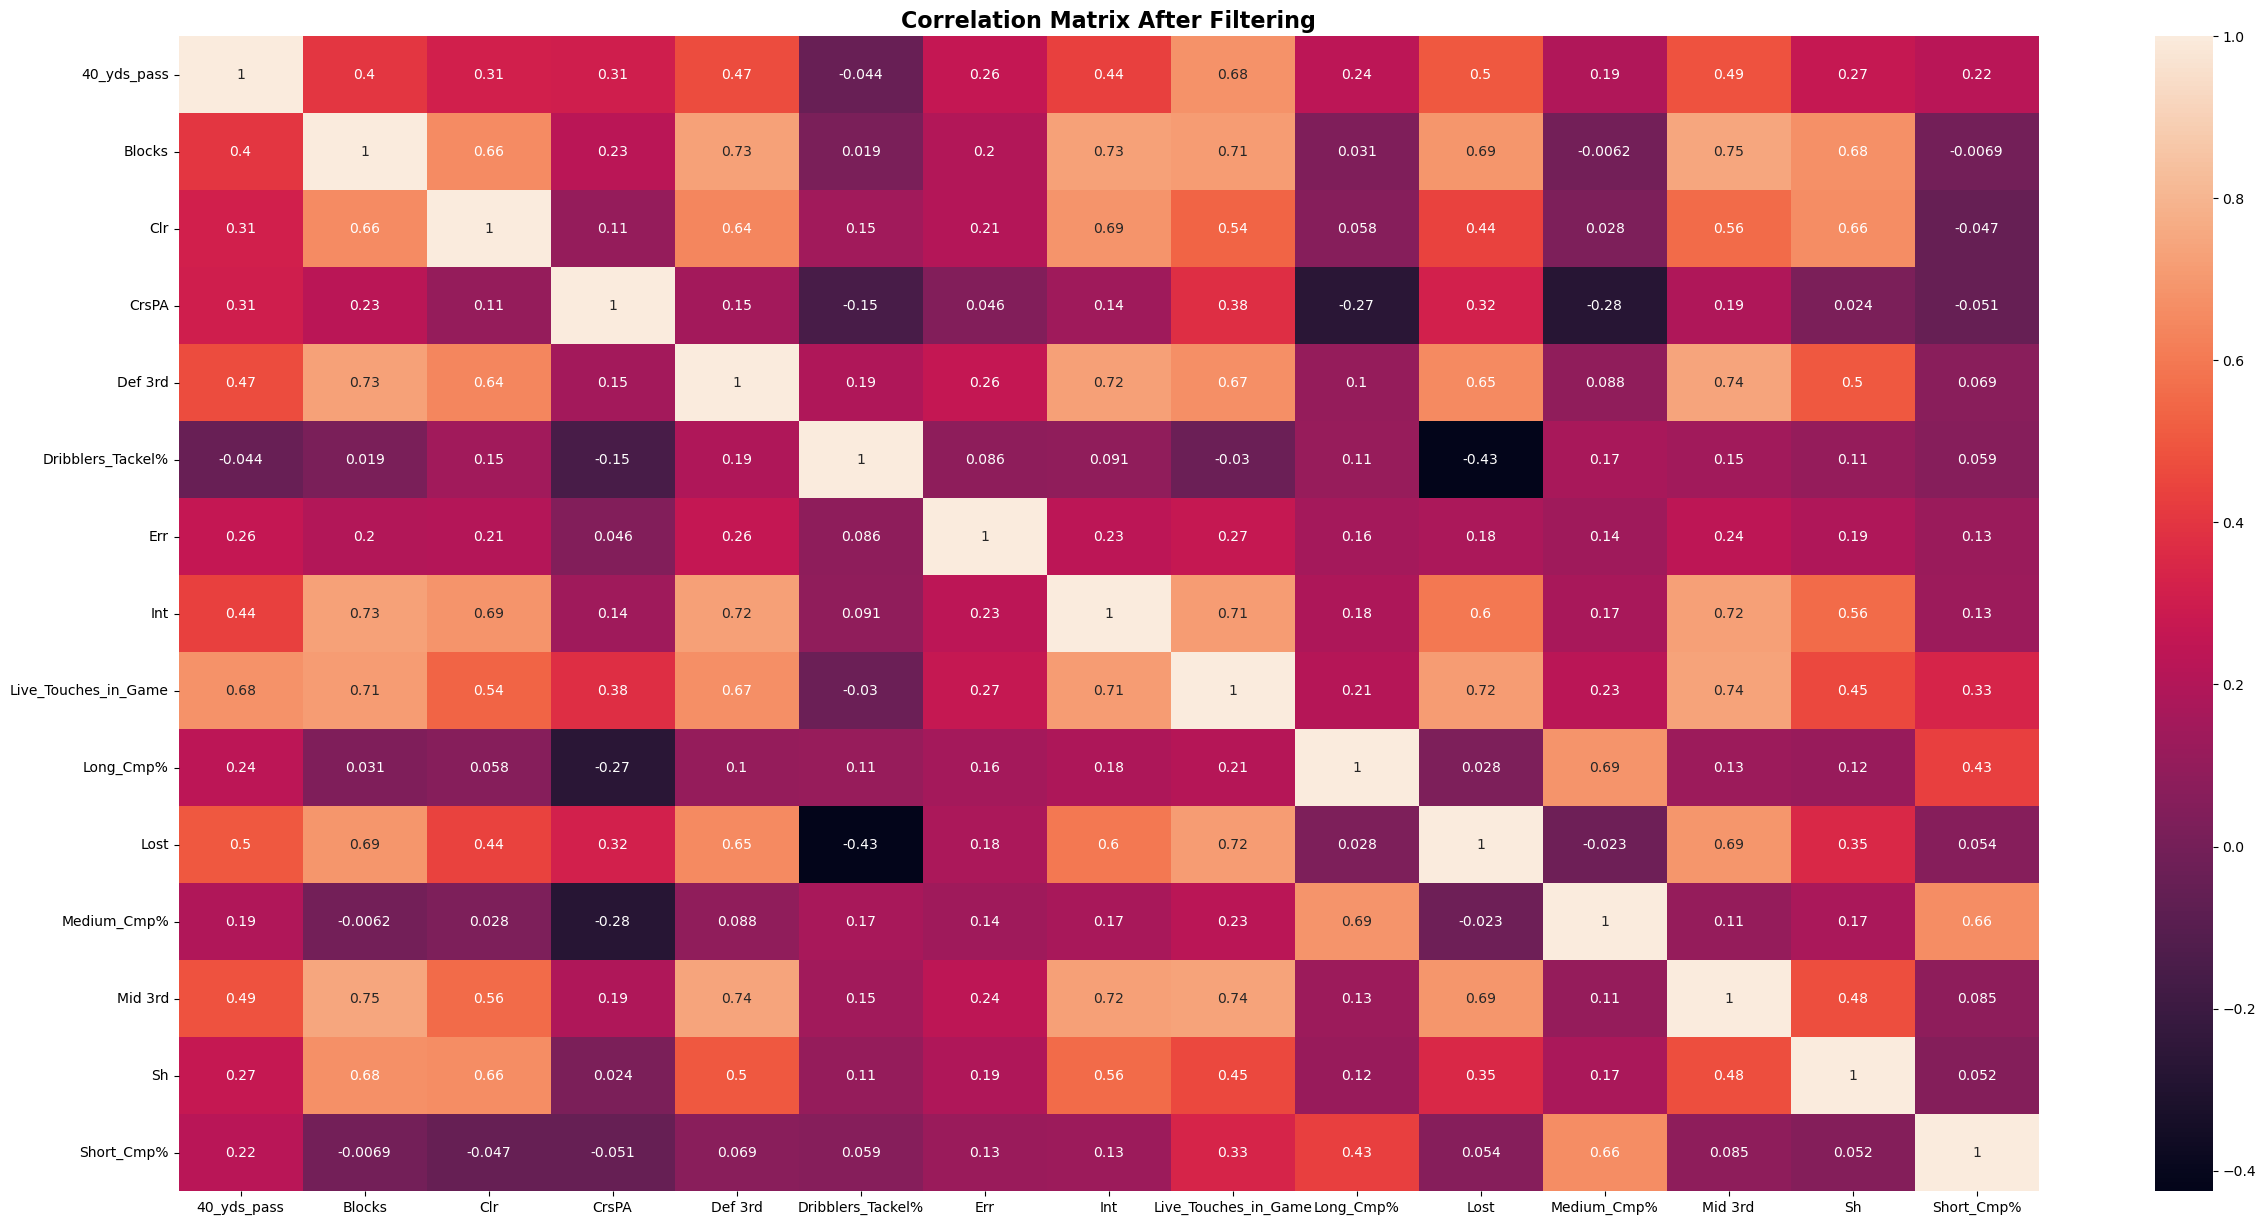

In [7]:
#filtered data frame
plt.figure(figsize=(30,15))
corr_matrix=df_filtered.corr(method='spearman')
sns.heatmap(corr_matrix,annot=True)
plt.title('Correlation Matrix After Filtering',size=16,fontweight='bold')

These are the remaining columns after the correlation filter. But we are performing cluster analysis, which requieres domain knowledge as well. Therefore, we will use the filtered dataframe as a base and remove and add columns which will help to get the characteristic of the holding six.

Following column(s) will be added:

- Touches_Def_Pen_Area
- Touches_Def_3rd_Area

Following column(s) will be removed:

- Err
- 40_yds_pass
- Sh
- Live_Touches_in_Game
- Mid 3rd

In [8]:
#added columns
df_filtered['Touches_Def_Pen_Area']=df_mf_['Touches_Def_Pen_Area']
df_filtered['Touches_Def_3rd_Area']=df_mf_['Touches_Def_3rd_Area']

#dropped columns
df_filtered.drop(['Err','40_yds_pass','Sh','Live_Touches_in_Game','Mid 3rd'],axis=1,inplace=True)

After filtering based on a correlation level threshold and adding columns based on our domain knowledge, we are left with 11 columns. Looking at these columns, we can confirm that all four characteristics of the holding six are still represented with at least one feature.

Next we look at the variance of the remaining features.

#### Variance

<Axes: ylabel='Count'>

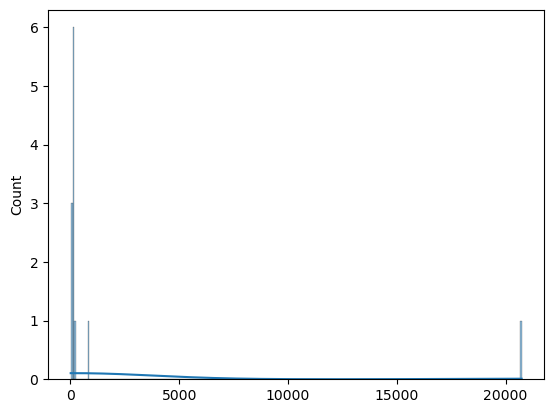

In [9]:
sns.histplot(df_filtered.var(),bins='fd',kde=True)

The variance of the different features does not follow a normal distribution, rather a bi-/tri-modal distribution.

In [10]:
#all remaining features show a high level of variance
df_filtered.var()

Blocks                    146.102427
Clr                       241.524872
CrsPA                      13.023499
Def 3rd                   107.668674
Dribblers_Tackel%         127.734342
Int                       170.758570
Long_Cmp%                 126.470358
Lost                      171.452950
Medium_Cmp%                38.781538
Short_Cmp%                 19.817835
Touches_Def_Pen_Area      853.684945
Touches_Def_3rd_Area    20738.685702
dtype: float64

Next we do a dimension reduction to see how the clusters behave, are they well separated, do they overlap. We have three options, PCA, UMAP and t-SNE, PCA is good for linear data, UMAP and t-SNE for non-linear data. How do we know if the data is linear or non-linear? We will run a PCA and get the variance explanation value, if two features explain more than 80% of the variance then we have linear data, otherwise non-linear. If the data is linear we will use PCA, otherwise we will use UMAP or t-SNE, we will use UMAP for this project because of its computational efficiency. Dimension reduction requires scaling, due to the outliers that we have left in the data, we need to address this with the RobustScaler, we do not use PowerTransformer because we do not want to lose the unique characteristics of the features.

### Dimenstion Reduction

Text(0.5, 1.0, 'Explained Variance by Features')

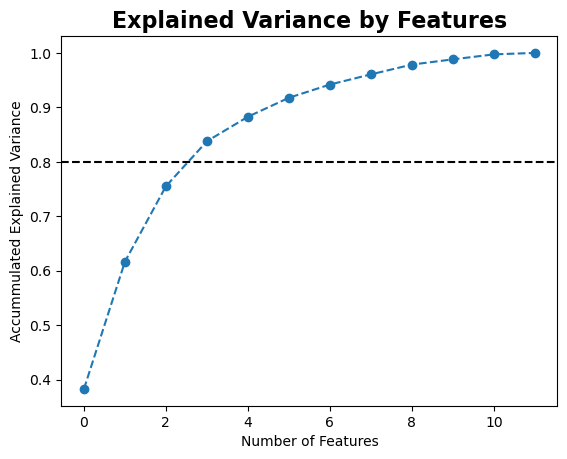

In [11]:
scaler=RobustScaler()
X_scaled=scaler.fit_transform(df_filtered)

pca=PCA(n_components=len(list(df_filtered.columns)))
X_PCA=pca.fit_transform(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_),marker='o',linestyle='--')
plt.axhline(0.8,ls='--',c='black')
plt.ylabel('Accummulated Explained Variance')
plt.xlabel('Number of Features')
plt.title('Explained Variance by Features',size=16,fontweight='bold')

As we can see, it takes up to four features to explain more than 80% of the variance, indicating that we are dealing with non-linearity. Next, we will use the UMAP to see how the clusters behave, whether they overlap, are well separated, etc.

[I 2025-03-01 22:52:50,255] A new study created in memory with name: no-name-2fb31de5-9580-4b42-ad5a-6956af8404e3
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2312521095.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_dist = trial.suggest_uniform('min_dist', 0.1, 0.9)
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2312521095.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 100.0)
C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-01 22:52:54,507] Tri

Best parameters: {'n_neighbors': 40, 'min_dist': 0.10318764683707356, 'learning_rate': 0.0010187251704560003, 'metric': 'manhattan'}
Best KNN-based score: 0.10499848875422191


Text(0.5, 1.0, 'Scatterplot UMAP Without Clusters')

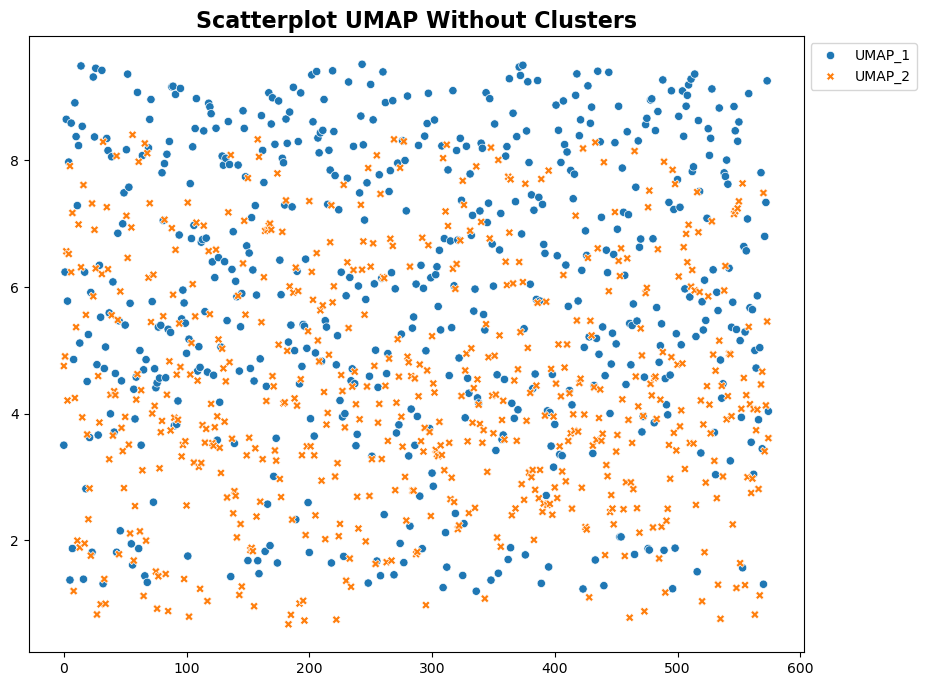

In [12]:
def objective(trial):
    #suggested hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_uniform('min_dist', 0.1, 0.9)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 100.0)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine', 'correlation'])

    #initialize UMAP with the suggested hyperparameters
    umap_model = umap.UMAP(n_components=2,n_neighbors=n_neighbors, min_dist=min_dist, 
                           learning_rate=learning_rate, metric=metric)

    #fit UMAP and transform the data
    X_umap = umap_model.fit_transform(df_filtered)

    #KNN-based evaluation (using NearestNeighbors)
    knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    knn.fit(X_umap)
    distances, _ = knn.kneighbors(X_umap)

    # We can evaluate based on the mean distance between nearest neighbors
    score = distances.mean()  # Negative because Optuna maximizes the objective
    return score

#define the search space and study
##KNN => need to look for the minimum
study_umap_2 = optuna.create_study(direction='minimize')
study_umap_2.optimize(objective, n_trials=50)

print("Best parameters:", study_umap_2.best_params)
print("Best KNN-based score:", study_umap_2.best_value)

scaler=RobustScaler()
X_scaled=scaler.fit_transform(df_filtered)

umap_module = umap.UMAP(n_components=2, n_neighbors=study_umap_2.best_params['n_neighbors'], min_dist=study_umap_2.best_params['min_dist'], learning_rate=study_umap_2.best_params['learning_rate']
                        ,metric=study_umap_2.best_params['metric'],random_state=101)

X_umap = umap_module.fit_transform(X_scaled)

df_umap = pd.DataFrame(X_umap, columns=['UMAP_1', 'UMAP_2'])

plt.figure(figsize=(10,8))
sns.scatterplot(df_umap)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Scatterplot UMAP Without Clusters',size=16,fontweight='bold')

The scatterplot shows that the data points overlap. This is important to know when selecting features.

[I 2025-03-01 22:53:14,230] A new study created in memory with name: no-name-4594a96e-d93b-44ae-9a3c-53930970c39e
[I 2025-03-01 22:53:14,246] Trial 0 finished with value: -4.731658042654118 and parameters: {'bandwidth': 2.9763514416313175}. Best is trial 0 with value: -4.731658042654118.
[I 2025-03-01 22:53:14,259] Trial 1 finished with value: -4.494606877720008 and parameters: {'bandwidth': 2.3357214690901213}. Best is trial 1 with value: -4.494606877720008.
[I 2025-03-01 22:53:14,272] Trial 2 finished with value: -3.8977190562993176 and parameters: {'bandwidth': 1.1288378916846888}. Best is trial 2 with value: -3.8977190562993176.
[I 2025-03-01 22:53:14,281] Trial 3 finished with value: -3.2577643082880057 and parameters: {'bandwidth': 0.26366508987303583}. Best is trial 3 with value: -3.2577643082880057.
[I 2025-03-01 22:53:14,293] Trial 4 finished with value: -3.3376696776982797 and parameters: {'bandwidth': 0.33598182862837817}. Best is trial 3 with value: -3.2577643082880057.
[I 

Best parameters: {'bandwidth': 0.1}
Best log_likelihood score: -2.7562460482273625


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\873216822.py:21: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_kde)


<Figure size 1000x600 with 0 Axes>

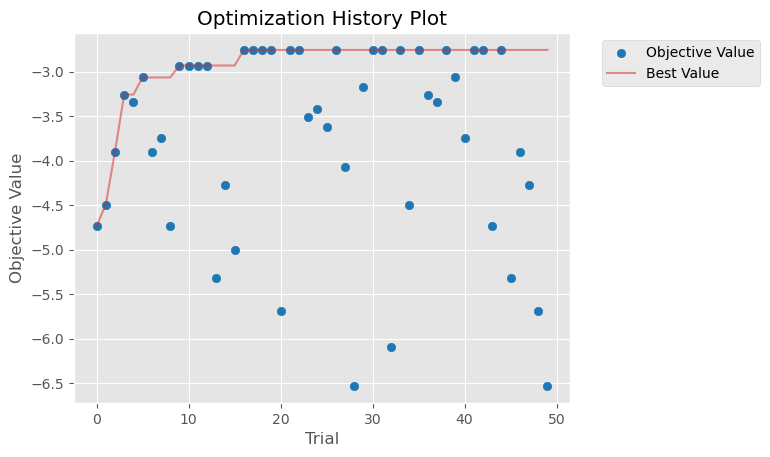

Text(0, 0.5, 'UMAP Dimension 2')

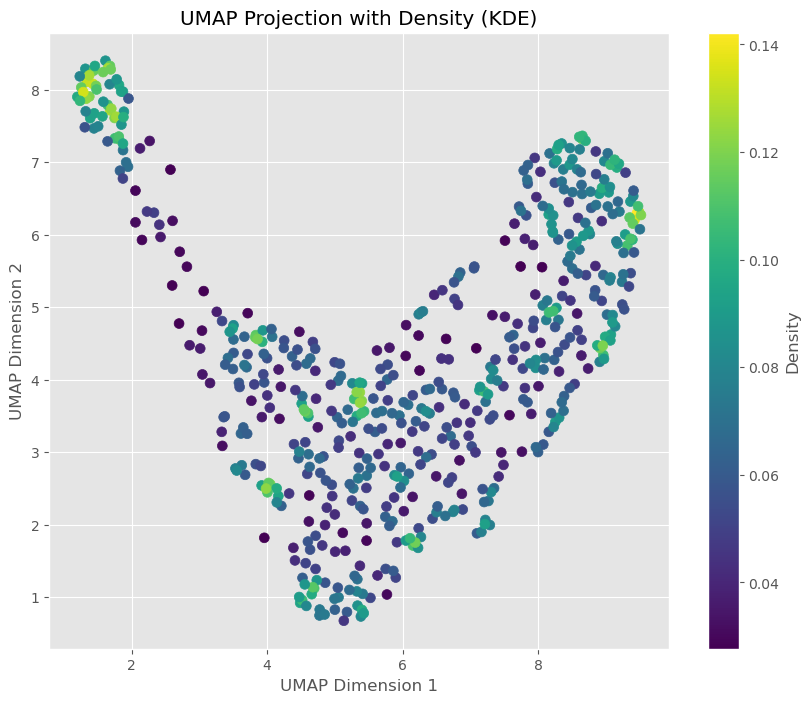

In [13]:
def log_likelihood_scorer(estimator, X):
    log_density = estimator.score_samples(X)  #log density for each sample => getting a couple of values
    return log_density.mean()  #mean log-likelihood

def objective(trial):
    bandwidth=trial.suggest_categorical('bandwidth', np.logspace(-1, 1, 20))

    kde=KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_umap)
    score=log_likelihood_scorer(kde,X_umap)
    return score

#we want to maximize the log-likelihood
#tpe is the default sampler and can be used for cluster analysis; but we want to set up a random seed to keep getting the same result when we run the code/model
study_kde = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=101))
study_kde.optimize(objective, n_trials=50)

print("Best parameters:", study_kde.best_params)
print("Best log_likelihood score:", study_kde.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_kde)
plt.show()

#apply KDE with the best bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=study_kde.best_params['bandwidth'])
kde.fit(X_umap)

#evaluate the density at all points in the UMAP space
density = np.exp(kde.score_samples(X_umap))  # Convert log-likelihood to density

#visualize the UMAP scatter plot with density
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=density, cmap='viridis', s=50)
plt.colorbar(label='Density')
plt.title('UMAP Projection with Density (KDE)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

Looking at the plot, we can see some separation, but eventually the data points seem to overlap. The data points are more concentrated at the edges (top left, top right and bottom). The centre becomes harder to separate into different clusters, but we see some contrasts in the middle that could act as boundaries to separate the clusters.

[I 2025-03-01 22:53:15,055] A new study created in memory with name: no-name-b6e46cc6-da62-411b-8490-95553a1fb0cb
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2612713071.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_dist = trial.suggest_uniform('min_dist', 0.1, 0.9)
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2612713071.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 100.0)
C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-01 22:53:15,410] Tri

Best parameters: {'n_neighbors': 20, 'min_dist': 0.10088596943149145, 'learning_rate': 0.004829067237040223, 'metric': 'euclidean'}
Best KNN-based score: 0.14207756283658257


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2612713071.py:32: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_umap_3)


<Figure size 1000x600 with 0 Axes>

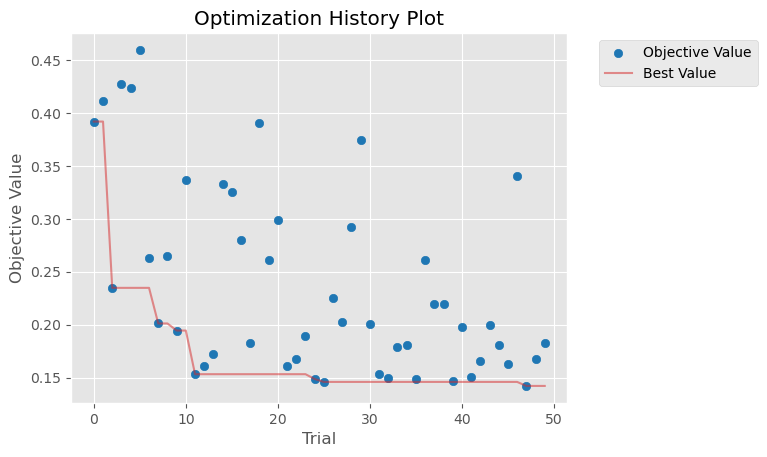

C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gandj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2612713071.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap="coolwarm", s=5, alpha=0.7)


Text(0.5, 0.92, '3D UMAP Visualization')

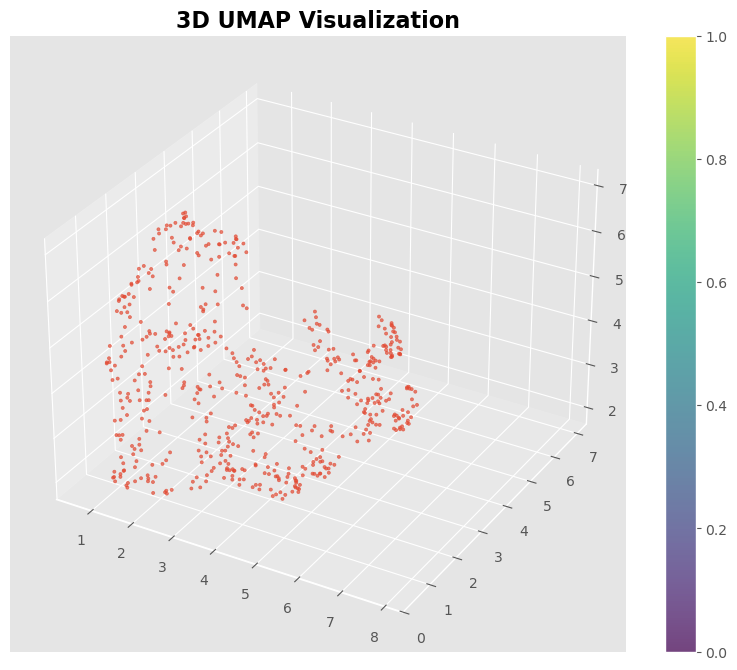

In [14]:
def objective(trial):
    #suggested hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_uniform('min_dist', 0.1, 0.9)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 100.0)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine', 'correlation'])

    #initialize UMAP with the suggested hyperparameters
    umap_model = umap.UMAP(n_components=3,n_neighbors=n_neighbors, min_dist=min_dist, 
                           learning_rate=learning_rate, metric=metric)

    #fit UMAP and transform the data
    X_umap = umap_model.fit_transform(df_filtered)

    #KNN-based evaluation (using NearestNeighbors)
    knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    knn.fit(X_umap)
    distances, _ = knn.kneighbors(X_umap)

    #we can evaluate based on the mean distance between nearest neighbors
    score = distances.mean()  #negative because Optuna maximizes the objective
    return score

#we want to minimize the KNN distance
study_umap_3 = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=101))
study_umap_3.optimize(objective, n_trials=50)

print("Best parameters:", study_umap_3.best_params)
print("Best KNN-based score:", study_umap_3.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_umap_3)
plt.show()

umap_module = umap.UMAP(n_components=3, n_neighbors=study_umap_3.best_params['n_neighbors'], min_dist=study_umap_3.best_params['min_dist'], learning_rate=study_umap_3.best_params['learning_rate']
                        ,metric=study_umap_3.best_params['metric'], random_state=101)
X_umap = umap_module.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap="coolwarm", s=5, alpha=0.7)
plt.colorbar(sc, ax=ax)
ax.set_title("3D UMAP Visualization",size=16,fontweight='bold')

When we plot the data in a three-dimensional graph we see that the cluster are overlapping, because they do not seperate well.

C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gandj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\2873536530.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap="coolwarm", s=5, alpha=0.7)
C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gandj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\gandj\A

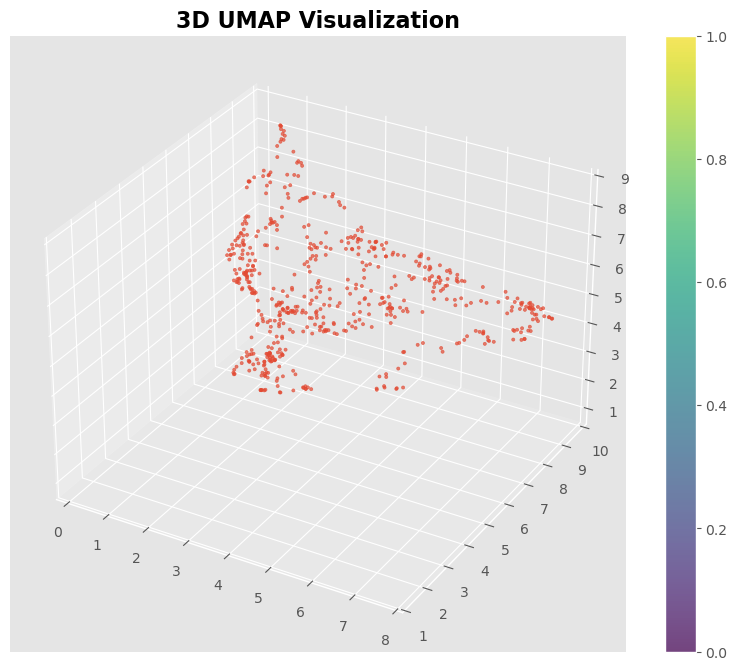

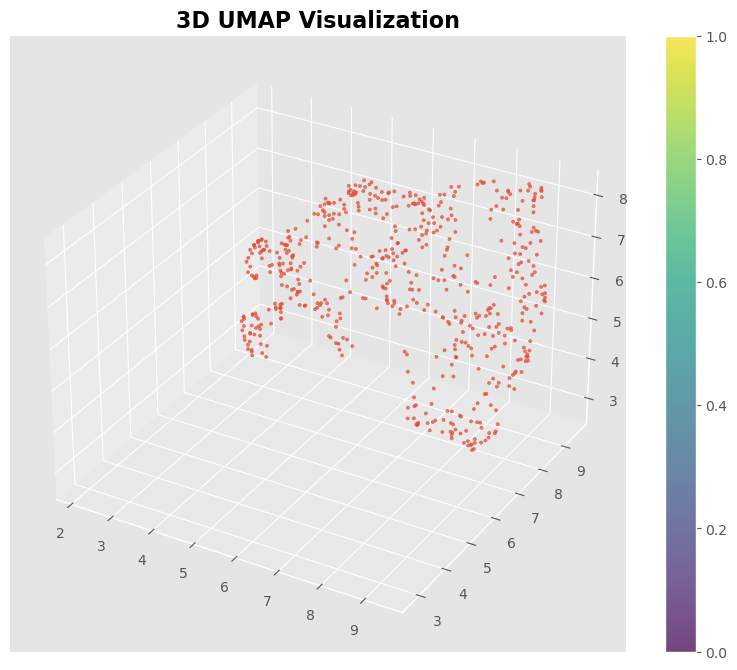

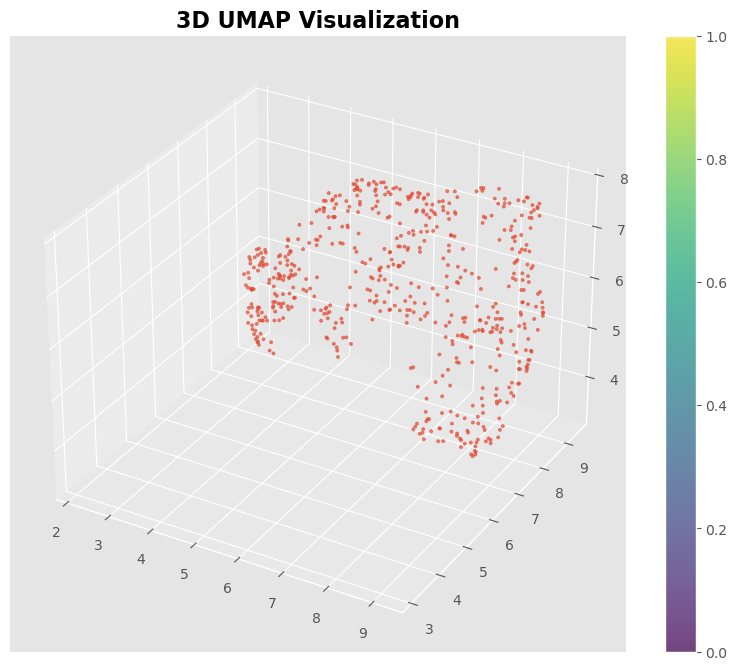

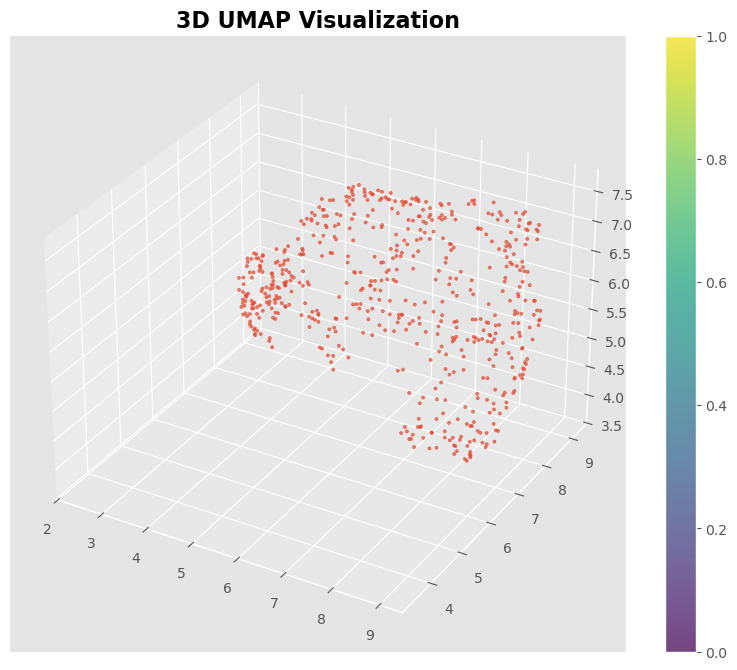

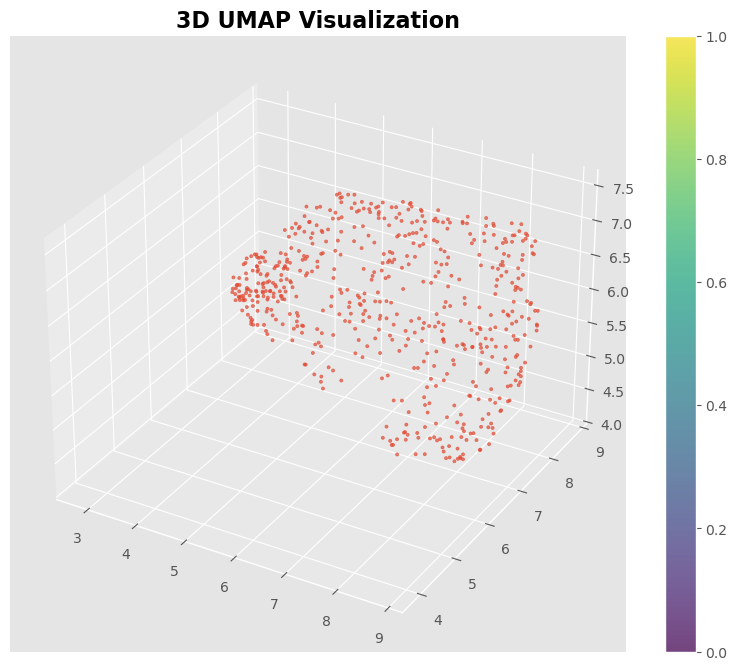

In [15]:
for x in [5,15,30,50,100]:
    umap_module = umap.UMAP(n_components=3, n_neighbors=x, min_dist=study_umap_3.best_params['min_dist'], learning_rate=study_umap_3.best_params['learning_rate']
                        ,metric=study_umap_3.best_params['metric'], random_state=101)
    X_umap = umap_module.fit_transform(X_scaled)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap="coolwarm", s=5, alpha=0.7)
    plt.colorbar(sc, ax=ax)
    ax.set_title("3D UMAP Visualization",size=16,fontweight='bold')

We can see a similar picture, the data does not separate easily and tends to overlap.

The next step is to select the appropriate cluster models. We are dealing with non-linear, overlapping data and we do not know exactly how many clusters we have.

Based on this information, the following cluster models will help us to find six players

- DBSCAN => deals with non-linear data; overlapping clusters; model does not need a predefined number of clusters; deals with outliers
- GMM => can deal with unclear density of clusters/data; can deal with overlapping clusters
- HDBSCAN => can deal with varying density of data; can deal with outliers; model does not need a predefined number of clusters
- Means Shift => due to the overlapping concentration peaks of data points can lead to clusters that will discover Means Shift; model does not need a predefined number of clusters; handles outliers.

We will feed the dimensionally reduced data into these models. Another important aspect that we need to point out is that we will try different methods to optimise the different cluster models.

**DBSCAN
- Elbow method => NearestNeighbour
- GridSearch Approach => Scoring Metric Silhoutte Score

**DBSCAN
-GridSearch Approach

**GMM
- Elbow method => bics
- GridSearch Approach => Scoring Metric Silhoutte Score

**Mean shift** -GridSearch Approach
-GridSearch Approach => Scoring Metric Silhoutte Score

We will mainly focus on the GridSearch approach, so we will evaluate all models using the same aspects (Silhoutte Score, Dunn Index and Calinski-Harabasz Score). We choose these three metrics because each tells us something different.

**Silhoutte Score**

Measures how similar a point is to its own cluster compared to other clusters (good for well-separated clusters)

**Dunn Index**

Focuses on the ratio of the smallest inter-cluster distance to the largest intra-cluster distance (good for compact and well-separated clusters).

**Calinski-Harabasz score**

Measures the ratio of the sum of the inter-cluster dispersion to the intra-cluster dispersion (good for assessing overall structure).

We will use the Silhoutte score to find the best hyperparameters, the Calinski-Harabasz score to compare the models and finally the Dunn index as a tie-breaker if needed.

## Cluster Analysis

In [16]:
scaler=RobustScaler()
X_scaled=scaler.fit_transform(df_filtered)

umap_module = umap.UMAP(n_components=2, n_neighbors=study_umap_2.best_params['n_neighbors'], min_dist=study_umap_2.best_params['min_dist'], learning_rate=study_umap_2.best_params['learning_rate']
                        ,metric=study_umap_2.best_params['metric'],random_state=101)

X_umap = umap_module.fit_transform(X_scaled)
df_umap = pd.DataFrame(X_umap, columns=['UMAP_1', 'UMAP_2'])

#setting up an empty dict, which we will use to save the scoring metrics for the different models
cluster_model_performance={}

C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gandj\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
def dunn_index(X, labels):
    clusters = np.unique(labels)
    intra_distances = []
    inter_distances = []

    #compute the pairwise distances between points
    dist_matrix = pairwise_distances(X)

    for cluster in clusters:
        #extract the points for this cluster
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            #calculate the maximum pairwise distance within the cluster (intra-cluster)
            intra_distances.append(np.max(pairwise_distances(cluster_points)))
        
        #calculate the minimum pairwise distance between points of different clusters (inter-cluster)
        for other_cluster in clusters:
            if cluster != other_cluster:
                other_cluster_points = X[labels == other_cluster]
                inter_distances.append(np.min(pairwise_distances(cluster_points, other_cluster_points)))
    
    #Dunn Index: Minimum inter-cluster distance / Maximum intra-cluster distance
    return np.min(inter_distances) / np.max(intra_distances)

[I 2025-03-01 22:53:40,470] A new study created in memory with name: no-name-5cb07fac-713f-4054-b441-44deca47c392
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\distributions.py:684: UserWarning: The distribution is specified by [0.1, 5] and step=50, but the range is not divisible by `step`. It will be replaced by [0.1, 0.1].
  warnings.warn(
[I 2025-03-01 22:53:40,484] Trial 0 finished with value: -0.48163363337516785 and parameters: {'eps_values': 0.1, 'min_samples': 3}. Best is trial 0 with value: -0.48163363337516785.
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\distributions.py:684: UserWarning: The distribution is specified by [0.1, 5] and step=50, but the range is not divisible by `step`. It will be replaced by [0.1, 0.1].
  warnings.warn(
[I 2025-03-01 22:53:40,495] Trial 1 finished with value: -0.5945696234703064 and parameters: {'eps_values': 0.1, 'min_samples': 4}. Best is trial 0 with value: -0.48163363337516785.
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\dis

Best parameters: {'eps_values': 0.1, 'min_samples': 3}
Best Silhouette Score: -0.48163363337516785


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\1207994395.py:21: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_dbscan)


<Figure size 1000x600 with 0 Axes>

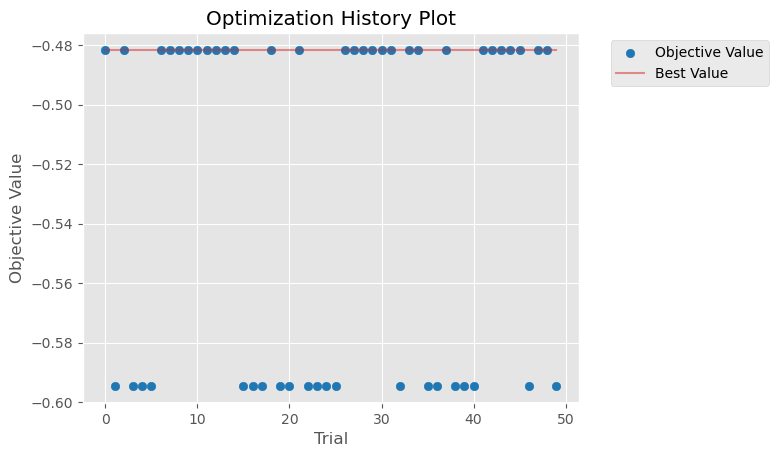

Silhouett Score: -0.48163363337516785
Dunn Index: 0.01158780325204134
Calinski Harabasz Score: 8.679176591029957


In [18]:
#DBSCAN
def objective(trial):
    eps_values=trial.suggest_float('eps_values',0.1,5,step=50)
    min_samples=trial.suggest_int('min_samples', 3, 4)

    cluster_dbscan=DBSCAN(eps=eps_values,min_samples=min_samples)
    labels=cluster_dbscan.fit_predict(X_umap)

    #if the length of the labels is bigger than 1 calculate the silhouett score, otherwise return -1
    if len(set(labels)) > 1:
        score=silhouette_score(X_umap,labels)
        return score
    return -1

#using random sampler
study_dbscan=optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=101))
study_dbscan.optimize(objective,n_trials=50)

print("Best parameters:", study_dbscan.best_params)
print("Best Silhouette Score:", study_dbscan.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_dbscan)
plt.show()

final_dbscan=DBSCAN(eps=study_dbscan.best_params['eps_values'],min_samples=study_dbscan.best_params['min_samples'])
labels_dbscan=final_dbscan.fit_predict(X_umap)

silhouett_score=silhouette_score(X_umap,labels_dbscan)
dunn_index_score=dunn_index(X_umap,labels_dbscan)
ch_score=calinski_harabasz_score(X_umap,labels_dbscan)

print(f'Silhouett Score: {silhouett_score}')
print(f'Dunn Index: {dunn_index_score}')
print(f'Calinski Harabasz Score: {ch_score}')

#creating a dict for each model with the metrics
dict_dbscan={'Silhouett Score':silhouett_score,'Dunn Index':dunn_index_score,'Calinski Harabasz Score':ch_score}
#putting the model dict in the overall performance dict
cluster_model_performance['DBSCAN']=dict_dbscan

[I 2025-03-01 22:53:41,275] A new study created in memory with name: no-name-52f1e4f2-d24f-4ae3-86b6-4faaf6a730e4
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [5, 20] and step=4, but the range is not divisible by `step`. It will be replaced by [5, 17].
  warnings.warn(
[I 2025-03-01 22:53:41,289] Trial 0 finished with value: 0.30796918272972107 and parameters: {'epsilon': 0.6958422390123339, 'min_samples': 5, 'min_cluster_size': 32}. Best is trial 0 with value: 0.30796918272972107.
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [5, 20] and step=4, but the range is not divisible by `step`. It will be replaced by [5, 17].
  warnings.warn(
[I 2025-03-01 22:53:41,301] Trial 1 finished with value: 0.3460182845592499 and parameters: {'epsilon': 1.9426974453948147, 'min_samples': 17, 'min_cluster_size': 47}. Best is trial 1 with value: 0.3460182845592

Best parameters: {'epsilon': 1.9426974453948147, 'min_samples': 17, 'min_cluster_size': 47}
Best Silhouette Score: 0.3460182845592499


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\917631165.py:23: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_hdbscan)


<Figure size 1000x600 with 0 Axes>

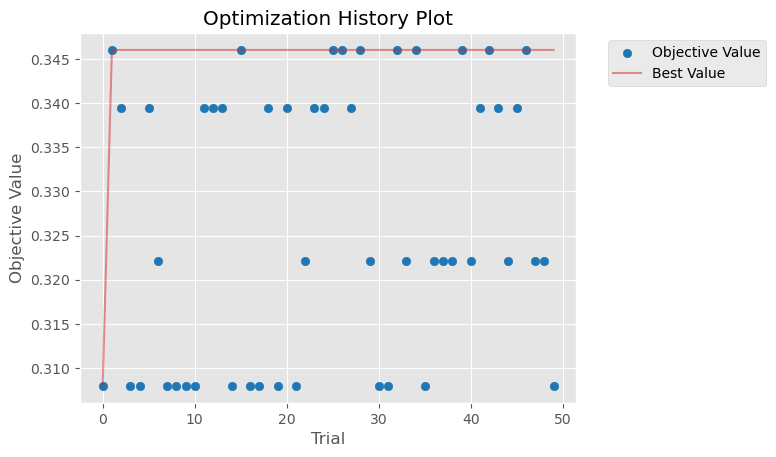

Silhouett Score: 0.3460182845592499
Dunn Index: 0.023913003504276276
Calinski Harabasz Score: 185.27395256840137


In [19]:
#HDBSCAN
def objective(trial):
    epsilon=trial.suggest_float('epsilon',0.1,2)
    min_samples=trial.suggest_int('min_samples',5,20,step=4)
    min_cluster_size=trial.suggest_int('min_cluster_size',5,50)

    cluster_hdbscan=HDBSCAN(min_cluster_size=min_cluster_size,cluster_selection_epsilon=epsilon,min_samples=min_samples)
    labels=cluster_hdbscan.fit_predict(X_umap)

    if len(set(labels)) > 1:
        score=silhouette_score(X_umap,labels)
        return score
    return -1

study_hdbscan=optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=101))
#without n_trials => we want to try every hyperparameter combination
study_hdbscan.optimize(objective,n_trials=50)

print("Best parameters:", study_hdbscan.best_params)
print("Best Silhouette Score:", study_hdbscan.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_hdbscan)
plt.show()

final_hdbscan=HDBSCAN(min_cluster_size=study_hdbscan.best_params['min_cluster_size'],cluster_selection_epsilon=study_hdbscan.best_params['epsilon'],min_samples=study_hdbscan.best_params['min_samples'])
labels_hdbscan=final_hdbscan.fit_predict(X_umap)

silhouett_score=silhouette_score(X_umap,labels_hdbscan)
dunn_index_score=dunn_index(X_umap,labels_hdbscan)
ch_score=calinski_harabasz_score(X_umap,labels_hdbscan)

print(f'Silhouett Score: {silhouett_score}')
print(f'Dunn Index: {dunn_index_score}')
print(f'Calinski Harabasz Score: {ch_score}')

dict_hdbscan={'Silhouett Score':silhouett_score,'Dunn Index':dunn_index_score,'Calinski Harabasz Score':ch_score}
cluster_model_performance['HDBSCAN']=dict_dbscan

[I 2025-03-01 22:53:42,024] A new study created in memory with name: no-name-6bcee06c-5382-4deb-8751-5938c5c1ac3b
C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
[I 2025-03-01 22:53:42,224] Trial 0 finished with value: 0.4723009765148163 and parameters: {'n_components': 4, 'covariance_type': 'tied'}. Best is trial 0 with value: 0.4723009765148163.
C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
[I 2025-03-01 22:53:42,252] Trial 1 finished with value: 0.39052847027778625 and parameters: {'n_components': 15, 'covaria

Best parameters: {'epsilon': 1.9426974453948147, 'min_samples': 17, 'min_cluster_size': 47}
Best Silhouette Score: 0.3460182845592499


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\3502026508.py:22: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_gmm)


<Figure size 1000x600 with 0 Axes>

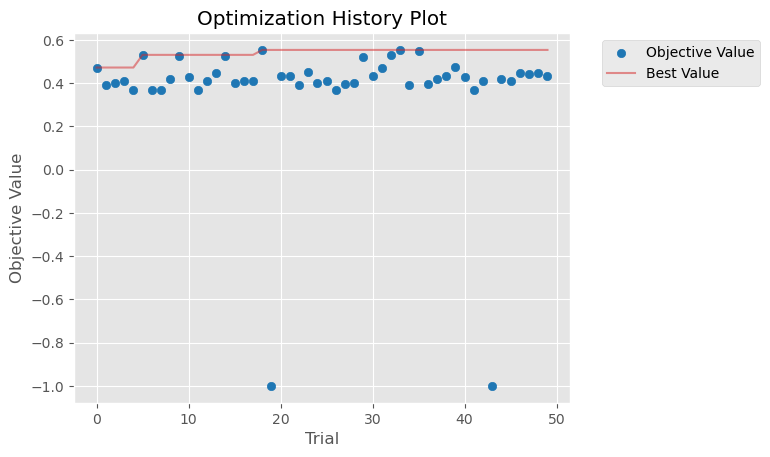

Silhouett Score: 0.5537154078483582
Dunn Index: 0.03463975712656975
Calinski Harabasz Score: 988.9953426574803


C:\Users\gandj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [20]:
#GMM
def objective(trial):
    n_components=trial.suggest_int('n_components',1,15)
    covariance_type=trial.suggest_categorical('covariance_type',['full','tied','diag','spherical'])

    cluster_gmm=GaussianMixture(n_components=n_components,covariance_type=covariance_type,random_state=101)
    labels=cluster_gmm.fit_predict(X_umap)

    if len(set(labels)) > 1:
        score=silhouette_score(X_umap,labels)
        return score
    return -1

study_gmm=optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=101))
#without n_trials => we want to try every hyperparameter combination
study_gmm.optimize(objective,n_trials=50)

print("Best parameters:", study_hdbscan.best_params)
print("Best Silhouette Score:", study_hdbscan.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_gmm)
plt.show()

final_gmm=GaussianMixture(n_components=study_gmm.best_params['n_components'],covariance_type=study_gmm.best_params['covariance_type'],random_state=101)
labels_gmm=final_gmm.fit_predict(X_umap)

silhouett_score=silhouette_score(X_umap,labels_gmm)
dunn_index_score=dunn_index(X_umap,labels_gmm)
ch_score=calinski_harabasz_score(X_umap,labels_gmm)

print(f'Silhouett Score: {silhouett_score}')
print(f'Dunn Index: {dunn_index_score}')
print(f'Calinski Harabasz Score: {ch_score}')

dict_gmm={'Silhouett Score':silhouett_score,'Dunn Index':dunn_index_score,'Calinski Harabasz Score':ch_score}
cluster_model_performance['GMM']=dict_gmm

[I 2025-03-01 22:53:44,330] A new study created in memory with name: no-name-81ad6b20-46b4-4554-9631-13850002e09b
[I 2025-03-01 22:53:44,369] Trial 0 finished with value: -1.0 and parameters: {'bandwidth': 4.652959954108929, 'bin_seeding': True, 'min_bin_freq': 8}. Best is trial 0 with value: -1.0.
[I 2025-03-01 22:53:45,797] Trial 1 finished with value: 0.38081029057502747 and parameters: {'bandwidth': 1.0004477872761546, 'bin_seeding': False, 'min_bin_freq': 5}. Best is trial 1 with value: 0.38081029057502747.
[I 2025-03-01 22:53:45,872] Trial 2 finished with value: 0.44629421830177307 and parameters: {'bandwidth': 1.645328162120125, 'bin_seeding': True, 'min_bin_freq': 8}. Best is trial 2 with value: 0.44629421830177307.
[I 2025-03-01 22:53:45,939] Trial 3 finished with value: -1.0 and parameters: {'bandwidth': 3.40398064517291, 'bin_seeding': True, 'min_bin_freq': 8}. Best is trial 2 with value: 0.44629421830177307.
[I 2025-03-01 22:53:47,192] Trial 4 finished with value: 0.5532638

Best parameters: {'bandwidth': 2.5079470497270515, 'bin_seeding': True, 'min_bin_freq': 6}
Best Silhouette Score: 0.5539319515228271


C:\Users\gandj\AppData\Local\Temp\ipykernel_73440\835114644.py:23: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_ms)


<Figure size 1000x600 with 0 Axes>

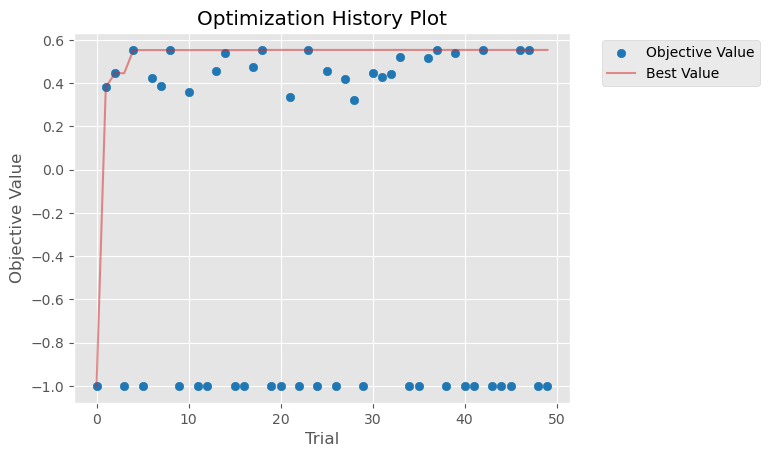

Silhouett Score: 0.5539319515228271
Dunn Index: 0.014454463496804237
Calinski Harabasz Score: 991.5935214875942


In [21]:
#MeanShift
def objective(trial):
    bandwidth=trial.suggest_float('bandwidth',0.5,5.0)
    bin_seeding=trial.suggest_categorical('bin_seeding',[True,False])
    min_bin_freq=trial.suggest_int('min_bin_freq',5,10)

    cluster_ms=MeanShift(bandwidth=bandwidth,bin_seeding=bin_seeding,min_bin_freq=min_bin_freq)
    labels=cluster_ms.fit_predict(X_umap)

    if len(set(labels)) > 1:
        score=silhouette_score(X_umap,labels)
        return score
    return -1

study_ms=optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=101))
#without n_trials => we want to try every hyperparameter combination
study_ms.optimize(objective,n_trials=50)

print("Best parameters:", study_ms.best_params)
print("Best Silhouette Score:", study_ms.best_value)

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_ms)
plt.show()

final_ms=MeanShift(bandwidth=study_ms.best_params['bandwidth'],bin_seeding=study_ms.best_params['bin_seeding'],min_bin_freq=study_ms.best_params['min_bin_freq'])
labels_ms=final_ms.fit_predict(X_umap)

silhouett_score=silhouette_score(X_umap,labels_ms)
dunn_index_score=dunn_index(X_umap,labels_ms)
ch_score=calinski_harabasz_score(X_umap,labels_ms)

print(f'Silhouett Score: {silhouett_score}')
print(f'Dunn Index: {dunn_index_score}')
print(f'Calinski Harabasz Score: {ch_score}')

dict_ms={'Silhouett Score':silhouett_score,'Dunn Index':dunn_index_score,'Calinski Harabasz Score':ch_score}
cluster_model_performance['MeanShift']=dict_ms

In [22]:
model_performance=pd.DataFrame.from_records(cluster_model_performance)
model_performance.transpose()

Silhouett Score  Dunn Index  Calinski Harabasz Score
DBSCAN           -0.481634    0.011588                 8.679177
GMM               0.553715    0.034640               988.995343
HDBSCAN          -0.481634    0.011588                 8.679177
MeanShift         0.553932    0.014454               991.593521

After running our models we have the different scores which allow us to understand and compare the performance of the different models.
The Silhouett Score was used for hyperparameter tuning, but can give us a first indication of how well a model has performed. We can see from the Silhouette Score that MeanShift performed best. The Silhouette Score gives us an idea of how well separated the clusters are compared to their cohesion.
(-1 to -0.1 => bad; 0.0 to 0.5 => okay; 0.5 to 1.0 good)

Next we have the Dunn index, which gives us the ratio of the smallest inter-cluster distance to the largest intra-cluster distance, here the GMM model performs best, but all models show a rather weak Dunn index.
(< 0.1 => bad; 0.1 to 0.3 => okay; > 0.3 => good)
And our last metric, the Calinski Harabasz score, this metric allows us to compare the different models with each other to determine the best model. The ratio of inter-cluster dispersion (spread between clusters) to intra-cluster dispersion (spread within clusters) is represented by the Calinski Harabasz score. The MeanShift model has the highest Calinski Harabasz score, indicating that it is the best model, but cluster analysis is unsupervised and we cannot easily trust/use the score as in supervised machine learning, so we will evaluate each model to see if it gives us what we expect.

In [23]:
df_name=df_mf.reset_index()
df_name=df_name.iloc[:,[0,2,3,4,5,6]].copy()
df_stats=df_mf_.reset_index()

df_clusters=pd.merge(df_name,df_stats,on='index',how='inner')
df_clusters['DBSCAN']=labels_dbscan
df_clusters['HDBSCAN']=labels_hdbscan
df_clusters['GMM']=labels_gmm
df_clusters['MeanShift']=labels_ms

df_umap['DBSCAN']=labels_dbscan
df_umap['HDBSCAN']=labels_hdbscan
df_umap['GMM']=labels_gmm
df_umap['MeanShift']=labels_ms
#df_clusters[(df_clusters['DBSCAN']==-1)]['Player'].unique()

In [24]:
df_clusters['DBSCAN'].value_counts().to_frame().transpose()

DBSCAN  -1    8    2    14   3    12   20   26   31   17   13   9    15   5   \
count   442    7    7    5    5    5    5    5    4    4    4    4    4    4   

DBSCAN   4    25   21   11   30   23   24   16   33   22   27   28   10   0   \
count     4    4    4    4    3    3    3    3    3    3    3    3    3    3   

DBSCAN   7    6    18   34   19   1    29   32  
count     3    3    3    3    3    3    3    3

Text(0.5, 1.0, 'Scatterplot DBSCAN')

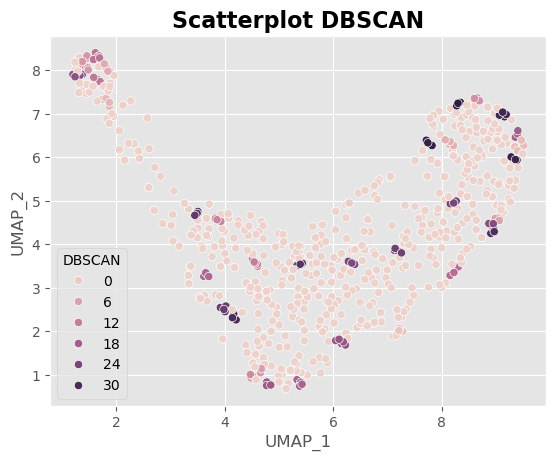

In [25]:
sns.scatterplot(x=df_umap['UMAP_1'],y=df_umap['UMAP_2'],hue=df_umap['DBSCAN'])
plt.title(f'Scatterplot DBSCAN',size=16,fontweight='bold')

As we can see, DBSCAN does not do a good job because it creates too many smaller subclusters instead of seeing the bigger picture. Based on the scores and the visualisation, we decide not to use DBSCAN as the final model.

In [26]:
df_clusters['HDBSCAN'].value_counts().to_frame().transpose()

HDBSCAN    0   1  -1
count    509  60   6

In [27]:
df_clusters[df_clusters['HDBSCAN']==0]['Player'].unique()

array(['Tyler Adams', 'Thiago Alcántara', 'Shandon Baptiste',
       'Rodrigo Bentancur', 'Yves Bissouma', 'Tom Cairney', 'Lewis Cook',
       'Danilo', 'Josh Dasilva', 'Kevin De Bruyne', 'Leander Dendoncker',
       'Kiernan Dewsbury-Hall', 'Ibrahima Diallo', 'Abdoulaye Doucouré',
       'Christian Eriksen', 'Enzo Fernández', 'Fred', 'Remo Freuler',
       'Conor Gallagher', 'James Garner', 'Billy Gilmour', 'João Gomes',
       'Pascal Groß', 'Bruno Guimarães', 'İlkay Gündoğan',
       'Jordan Henderson', 'Will Hughes', 'Vitaly Janelt',
       'Mathias Jensen', 'Curtis Jones', 'Jorginho', 'Boubacar Kamara',
       'Cheikhou Kouyaté', 'Mateo Kovačić', 'Roméo Lavia', 'Mario Lemina',
       'Ruben Loftus-Cheek', 'Sean Longstaff', 'Alexis Mac Allister',
       'Orel Mangala', 'Weston McKennie', 'Scott McTominay',
       'Nampalys Mendy', 'Luka Milivojević', 'James Milner',
       'João Moutinho', 'Matheus Nunes', 'Christian Nørgaard',
       'Amadou Onana', 'Frank Onyeka', 'Lucas Paquetá'

Text(0.5, 1.0, 'Scatterplot HDBSCAN')

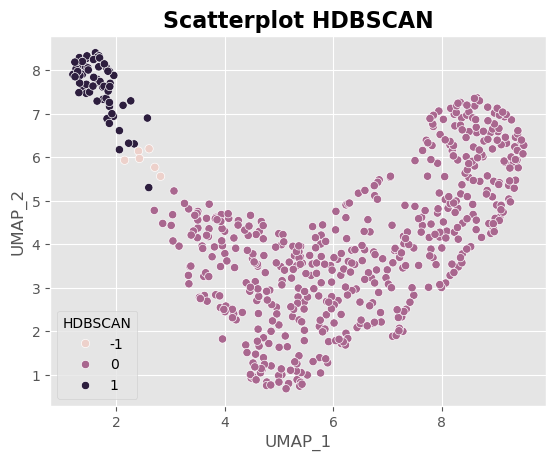

In [28]:
sns.scatterplot(x=df_umap['UMAP_1'],y=df_umap['UMAP_2'],hue=df_umap['HDBSCAN'])
plt.title(f'Scatterplot HDBSCAN',size=16,fontweight='bold')

Although the model has the same results as DBSCAN, HDBSCAN performs much better, the model allows us to separate the player much better, but still struggles to create a correct seerpation. Cluster 0 is the closest to the desired result for the HDBSCAN model. Cluster 0 contains a holding six, but also a more attacking midfielder.

Based on the results and the visualisation, we decide not to use HDBSCAN as the final model.

In [29]:
df_clusters['GMM'].value_counts().to_frame().transpose()

GMM      1    0   2
count  296  211  68

In [36]:
df_clusters[df_clusters['GMM']==2]['Player'].unique()

array(['Moisés Caicedo', 'Casemiro', 'Cheick Doucouré', 'Fabinho',
       'Idrissa Gana Gueye', 'Pierre Højbjerg', 'Jefferson Lerma',
       'Douglas Luiz', 'Wilfred Ndidi', 'Rúben Neves', 'João Palhinha',
       'Declan Rice', 'Rodri', 'Tomáš Souček', 'Samu Costa',
       'Omar Mascarell', 'Daniel Parejo', 'Guido Rodríguez',
       'Oriol Romeu', 'Vinicius Souza', 'Aurélien Tchouaméni',
       'Lucas Torró', 'Martín Zubimendi', 'Alexis Blin',
       'Lassana Coulibaly', 'Bryan Cristante', 'Morten Hjulmand',
       'Manuel Locatelli', 'Matteo Pessina', 'Marten de Roon',
       'Jerdy Schouten', 'Adrien Tameze', 'Walace', 'Laurent Abergel',
       'Benjamin André', 'Nabil Bentaleb', 'Xavier Chavalerin',
       'Joris Chotard', 'Youssouf Fofana', 'Rominigue Kouamé',
       'Enzo Le Fée', 'Pierre Lees-Melou', 'Yohann Magnin',
       'Azor Matusiwa', 'Thiago Mendes', 'Valentin Rongier',
       'Stijn Spierings', 'Birama Touré', 'Robert Andrich',
       'Maximilian Arnold', 'Wataru Endo', '

Text(0.5, 1.0, 'Scatterplot GMM')

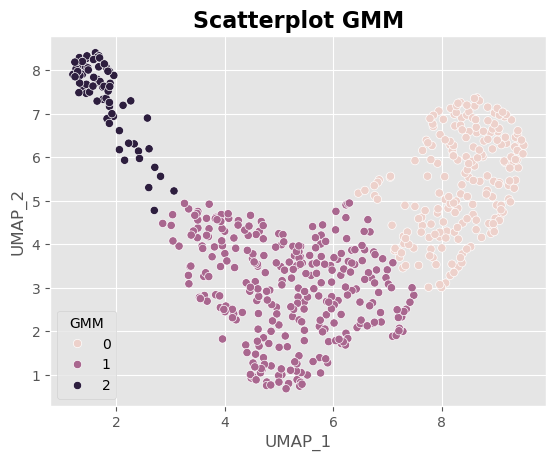

In [31]:
sns.scatterplot(x=df_umap['UMAP_1'],y=df_umap['UMAP_2'],hue=df_umap['GMM'])
plt.title(f'Scatterplot GMM',size=16,fontweight='bold')

The Gaussian Mixture (GMM) model has the second best scores, and if we simply based our decision on the scores we would not select this model, but when we look at the results we can see that the GMM model was able to get all the holding six players (domian knowledge, we know for sure that these players can play as holding six). We will also evaluate the final model and then make our decision, which model to choose.

In [32]:
df_clusters['MeanShift'].value_counts().to_frame().transpose()

MeanShift    0    1   2
count      292  215  68

In [35]:
#best cluster model in identifying all holding six plyer
df_clusters[df_clusters['MeanShift']==2]['Player'].unique()

array(['Moisés Caicedo', 'Casemiro', 'Cheick Doucouré', 'Fabinho',
       'Idrissa Gana Gueye', 'Pierre Højbjerg', 'Jefferson Lerma',
       'Douglas Luiz', 'Wilfred Ndidi', 'Rúben Neves', 'João Palhinha',
       'Declan Rice', 'Rodri', 'Tomáš Souček', 'Samu Costa',
       'Omar Mascarell', 'Daniel Parejo', 'Guido Rodríguez',
       'Oriol Romeu', 'Vinicius Souza', 'Aurélien Tchouaméni',
       'Lucas Torró', 'Martín Zubimendi', 'Alexis Blin',
       'Lassana Coulibaly', 'Bryan Cristante', 'Morten Hjulmand',
       'Manuel Locatelli', 'Matteo Pessina', 'Marten de Roon',
       'Jerdy Schouten', 'Adrien Tameze', 'Walace', 'Laurent Abergel',
       'Benjamin André', 'Nabil Bentaleb', 'Xavier Chavalerin',
       'Joris Chotard', 'Youssouf Fofana', 'Rominigue Kouamé',
       'Enzo Le Fée', 'Pierre Lees-Melou', 'Yohann Magnin',
       'Azor Matusiwa', 'Thiago Mendes', 'Valentin Rongier',
       'Stijn Spierings', 'Birama Touré', 'Robert Andrich',
       'Maximilian Arnold', 'Wataru Endo', '

Text(0.5, 1.0, 'Scatterplot GMM')

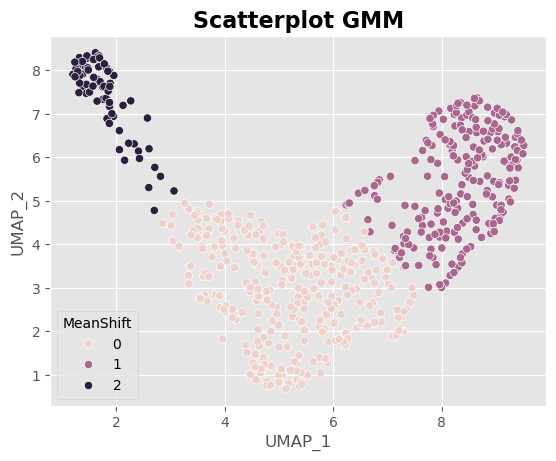

In [34]:
sns.scatterplot(x=df_umap['UMAP_1'],y=df_umap['UMAP_2'],hue=df_umap['MeanShift'])
plt.title(f'Scatterplot GMM',size=16,fontweight='bold')

The MeanShift model is able to identify all holding six players and has the highest scores, so we will use the MeanShift model result.

In [38]:
#final list of the holding six player
holding_six=df_clusters[df_clusters['MeanShift']==2]
holding_six.to_csv('Final_List_Holding_Six.csv')

## Summary

We were able to find the best fitting model, which allows us to seperate holding six player from the other middfield player. The best model was the GaussianMixture model, which performed well with unlinear data, which does not have a equal density along the different clusters.

## Sources

Watson (2022) What is a holding midfielder in soccer? (and how to play it), Soccer Coaching Pro. Available at: https://www.soccercoachingpro.com/holding-midfielder/ (Accessed: 22 October 2023)

Rousseeuw, P.J. (1987) ‘Silhouettes: A graphical aid to the interpretation and validation of cluster analysis’, Journal of Computational and Applied Mathematics, 20, pp. 53–65. doi:10.1016/0377-0427(87)90125-7. 